#  De belles cartes avec python: mise en pratique



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=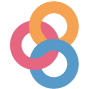)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/visualisation/maps.ipynb)

La pratique de la cartographie se fera, dans ce cours, en répliquant des cartes qu'on peut trouver sur
la page de l'*open-data* de la ville de Paris 
[ici](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name).

Produire de belles cartes demande du temps mais aussi du bon sens. En fonction de la structure des données, certaines représentations sont à éviter voire à exclure. L'excellent guide [disponible ici](https://juliedjidji.github.io/memocarto/semio.html) propose quelques règles et évoque les erreurs à éviter lorsqu'on désire effectuer des
représentations spatiales. 


Ce TP vise à initier:

* Au module graphique de [geopandas](https://geopandas.org/mapping.html) ainsi qu'aux packages [geoplot](https://residentmario.github.io/geoplot/index.html) et
[contextily](https://contextily.readthedocs.io/en/latest/intro_guide.html) pour la construction de cartes figées. `geoplot` est construit sur `seaborn` et constitue ainsi une extension des graphiques de base.
* Au package [folium](https://python-visualization.github.io/folium/) qui est un point d'accès vers la librairie JavaScript [leaflet](https://leafletjs.com/) permettant de produire des cartes interactives

Les données utilisées sont :

* Un sous-ensemble des données de [paris open data](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name) a été mis à disposition
sur {{< githubrepo >}} pour faciliter l'import (élimination des colonnes
qui ne nous servirons pas mais ralentissent l'import)
* [La localisation précise des stations](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
* [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

Dans la première partie, nous allons utiliser les packages suivants:


In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geoplot
import matplotlib.pyplot as plt
import folium

Certaines librairies géographiques dépendent de `rtree` qui est parfois difficile à installer. Pour installer `rtree`, le mieux est d'utiliser `anaconda`.

Installations préalables : 


In [ ]:
# Sur anaconda
conda install rtree --yes

In [ ]:
# Sur colab
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install geoplot

## Première carte avec l'API `matplotlib` de `geopandas`

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 1: Importer les données**

Importer les données de compteurs de vélos en deux temps.

1. D'abord, les comptages peuvent être trouvés à l'adresse <https://github.com/linogaliana/python-datascientist/raw/master/data/bike.csv>. :warning: Il s'agit de données
compressées au format `gzip`, il faut donc utiliser l'option `compression`. Nommer cet objet `comptages`.



2. Importer les données de localisation des compteurs à partir de l'url <https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `compteurs`.


3. On va également utiliser les données d'arrondissements de la ville de Paris. Importer ces données depuis <https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>. Nommer cet objet `arrondissements`.



4. Utiliser la méthode `plot` pour représenter les localisations des compteurs dans l'espace. C'est, on peut l'avouer, peu informatif sans apport extérieur. Il va donc falloir travailler un peu l'esthétique



On serait tenté de faire un *merge* de la base compteurs et comptages. En l'occurrence, il s'agirait d'un produit cartésien puisqu'il s'agit de faire exploser la base spatiale. Avec des données spatiales, c'est souvent une très mauvaise idée. Cela duplique les points, créant des difficultés à représenter les données mais aussi ralentit les calculs. Sauf à utiliser la méthode `dissolve` (qui va agréger *k* fois la même géométrie...), les géométries sont perdues lorsqu'on effectue des `groupby`.  



Maintenant, tout est prêt pour une première carte. `matplotlib` fonctionne selon
le principe des couches. On va de la couche la plus lointaine à celle le plus
en surface. L'exception est lorsqu'on ajoute un fond de carte `contextily` via
`ctx.add_basemap`: on met cet appel en dernier. 

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 2: Première carte**

Représenter une carte des `compteurs` avec le fonds de carte des `arrondissements`

  * Faire attention à avoir des arrondissements dont l'intérieur est transparent (argument à utiliser: `facecolor`).
  * Faire des bordures d'arrondissements noires et affichez les compteurs en rouge.
  * Pour obtenir un graphique plus grand, vous pouvez utiliser l'argument `figsize = (10,10)`.
  * Pour les localisations, les points doivent être rouges en étant plus transparent au centre (argument à utiliser: `alpha`) 



Vous devriez obtenir cette carte:




{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 3 : Ajouter un fonds de carte avec contextily**

Repartir de la carte précédente.

1. Utiliser `ctx.add_basemap` pour ajouter un fonds de carte. Pour ne pas afficher les axes, vous pouvez utiliser `ax.set_axis_off()`.

:warning: *Par défaut, `contextily` désire un système de projection (crs) qui est le Web Mercator (epsg: 3857). Il faut changer la valeur de l'argument `crs`.*

:warning: *Avec les versions anciennes des packages, il faut utiliser `.to_string` sur un objet CRS pour qu'il soit reconnu par `contextily`. Sur des versions récentes, la valeur numérique du code EPSG est suffisante.*




2. Trouver un fonds de carte plus esthétique, qui permette de visualiser les grands axes, parmi ceux possibles. Pour tester l'esthétique, vous pouvez utiliser [cet url](http://leaflet-extras.github.io/leaflet-providers/preview/index.html). La documentation de référence sur les tuiles disponibles est [ici](https://contextily.readthedocs.io/en/latest/providers_deepdive.html) 


Le principe de la *heatmap* est de construire, à partir d'un nuage de point bidimensionnel, une distribution 2D lissée. La méthode repose sur les estimateurs à noyaux qui sont des méthodes de lissage local. 


Pour le moment, la fonction  `geoplot.kdeplot` n'incorpore pas toutes les fonctionalités de `seaborn.kdeplot`. Pour être en mesure de construire une `heatmap` avec des données pondérées (cf. [cette issue dans le dépôt seaborn](https://github.com/mwaskom/seaborn/issues/1364)), il y a une astuce. Il faut simuler *k* points de valeur 1 autour de la localisation observée. La fonction ci-dessous, qui m'a été bien utile, est pratique


In [ ]:
import numpy as np
def expand_points(shapefile,
                  index_var = "grid_id",
                  weight_var = 'prop',
                  radius_sd = 100,
                  crs = 2154):
    """
    Multiply number of points to be able to have a weighted heatmap
    :param shapefile: Shapefile to consider
    :param index_var: Variable name to set index
    :param weight_var: Variable that should be used
    :param radius_sd: Standard deviation for the radius of the jitter
    :param crs: Projection system that should be used. Recommended option
      is Lambert 93 because points will be jitterized using meters
    :return:
      A geopandas point object with as many points by index as weight
    """

    shpcopy = shapefile
    shpcopy = shpcopy.set_index(index_var)
    shpcopy['npoints'] = np.ceil(shpcopy[weight_var])
    shpcopy['geometry'] = shpcopy['geometry'].centroid
    shpcopy['x'] = shpcopy.geometry.x
    shpcopy['y'] = shpcopy.geometry.y
    shpcopy = shpcopy.to_crs(crs)
    shpcopy = shpcopy.loc[np.repeat(shpcopy.index.values, shpcopy.npoints)]
    shpcopy['x'] = shpcopy['x'] + np.random.normal(0, radius_sd, shpcopy.shape[0])
    shpcopy['y'] = shpcopy['y'] + np.random.normal(0, radius_sd, shpcopy.shape[0])

    gdf = gpd.GeoDataFrame(
        shpcopy,
        geometry = gpd.points_from_xy(shpcopy.x, shpcopy.y),
        crs = crs)

    return gdf

{{% panel status="exercise" title="Exercice"
icon="fas fa-pencil-alt" %}}

**Exercice 4 : Data cleaning avant de pouvoir faire une heatmap**

1. Calculer le trafic moyen, pour chaque station, entre 7 heures et 10 heures (bornes incluses) et nommer cet objet `df1`. Faire la même chose, en nommant `df2`, pour le trafic entre 17 et 20 heures (bornes incluses)



2. Nous allons désormais préparer les données de manière à faire une heatmap. Après avoir compris ce que permet de faire la fonction `expand_points` ci-dessus, créer une fonction `explode_data` qui suive les étapes suivantes. 
  + Convertir un DataFrame dans le système de projection Lambert 93 (epsg: 2154)
  + Appliquer `expand_points` aux noms de variable adéquats. Vous pouvez fixer la valeur de `radius_sd` à `100`. 
  + Reconvertir l'output au format WGS84 (epsg: 4326)



3. Appliquer cette fonction à `df1` et `df2`





**Exercice 5 : Heatmap, enfin !**

Représenter, pour ces deux moments de la journée, la `heatmap` du trafic de vélo avec `geoplot.kdeplot`. Pour cela :

- Appliquer la fonction `geoplot.kdeplot` avec comme consignes :
    + d'utiliser les arguments `shade=True` et `shade_lowest=True` pour colorer l'intérieur des courbes de niveaux obtenues ; 
    + d'utiliser une palette de couleur rouge avec une transparence modérée (`alpha = 0.6`)
    + d'utiliser l'argument `clip` pour ne pas déborder hors de Paris (en cas de doute, se référer à l'aide de `geoplot.kdeplot`)
    + L'argument `bw` (pour *bandwidth*) détermine le plus ou moins fort lissage spatial. Vous pouvez partir d'un bandwidth égal à 0.01 et le faire varier pour voir l'effet sur le résultat 
    
- Ne pas oublier d'ajouter les arrondissements. Avec `geoplot`, il faut utiliser `geoplot.polyplot`. 







## Des cartes réactives grâce à `folium`

De plus en plus de données de visualisation reposent sur la cartographie réactive. Que ce soit dans l'exploration des données ou dans la représentation finale de résultats, la cartographie réactive est très appréciable. 

`folium` offre une interface très flexible et très facile à prendre à main. Les cartes sont construites grâce à la librairie JavaScript `Leaflet.js` mais, sauf si on désire aller loin dans la customisation du résultat, il n'est pas nécessaire d'avoir des notions dans le domaine. 

Un objet folium se construit par couche. La première est l'initialisation de la carte. Les couches suivantes sont les éléments à mettre en valeur. L'initialisation de la carte nécessite la définition d'un point central (paramètre `location`) et d'un zoom de départ (`zoom_start`). Plutôt que de fournir manuellement le point central et le zoom on peut :

1. Déterminer le point central en construisant des colonnes longitudes et latitudes et en prenant la moyenne de celles-ci ;
2. Utiliser la méthode `fit_bounds` qui cale la carte sur les coins sud-ouest et nord-est. En supposant que la carte s'appelle `m`, on fera `m.fit_bounds([sw, ne])`

Le bout de code suivant permet de calculer le centre de la carte


In [ ]:
compteurs['lon'] = compteurs.geometry.x
compteurs['lat'] = compteurs.geometry.y
center = compteurs[['lat', 'lon']].mean().values.tolist()
print(center)

```
## [48.85628803, 2.34339106]
```

Alors que le code suivant permet de calculer les coins:


In [ ]:
sw = compteurs[['lat', 'lon']].min().values.tolist()
ne = compteurs[['lat', 'lon']].max().values.tolist()
print(sw)

```
## [48.82024, 2.26542]
```

In [ ]:
print(ne)

```
## [48.89696, 2.40969]
```

Si un fond gris s'affiche, c'est qu'il y a un problème de localisation. Cela provient généralement d'un problème de projection ou d'une inversion des longitudes et latitudes. 

Les longitudes représentent les *x* (axe ouest-est) et les latitudes *y* (axe sud-nord). De manière contrintuitive, `folium` attend qu'on lui fournisse les données sous la forme `[latitude, longitude]` donc `[y,x]`


**Exercice 6 : Visualiser la localisation des stations**

1. Calculer le centre `center`de la carte des données `compteurs`. Il s'obtient en agrègeant l'ensemble des géométries, calculant le centroid et récupèrant la valeur sous forme de liste. Avec une logique similaire, calculez les bornes du sud-ouest `sw` et du nord-est `ne` de la carte. 


2. Représenter la localisation des stations en utilisant un zoom optimal. 





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_1b20cdd1162146828d9bbce7b0bdc4fc%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_1b20cdd1162146828d9bbce7b0bdc4fc%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_1b20cdd1162146828d9bbce7b0bdc4fc%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_1b20cdd1162146828d9bbce7b0bdc4fc%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85628803%2C%202.34339106%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_c07406dd97f34b26b85779ac6efe6e28%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d818ee91d6974028bd979eb9316bfd94%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_744911aca9d9470b93d13bd4fda346ae%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b1a3bb571ffb46e2a7d3eae153b84ec6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b1a3bb571ffb46e2a7d3eae153b84ec6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_744911aca9d9470b93d13bd4fda346ae.setContent%28html_b1a3bb571ffb46e2a7d3eae153b84ec6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d818ee91d6974028bd979eb9316bfd94.bindPopup%28popup_744911aca9d9470b93d13bd4fda346ae%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5e1cfc72dad548a1b8bf5bdf68fe5b80%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_33e982aebf154eb79fae8f515d22f5e8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_26f11418cc1c4364afb823395739567f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_26f11418cc1c4364afb823395739567f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_33e982aebf154eb79fae8f515d22f5e8.setContent%28html_26f11418cc1c4364afb823395739567f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5e1cfc72dad548a1b8bf5bdf68fe5b80.bindPopup%28popup_33e982aebf154eb79fae8f515d22f5e8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0b93b034e00a43bdb7164000a7e7ef83%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7265cd18ceaf43acbc292c03c8c76c75%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_56e3767eae91458c9344015e9acdaca3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_56e3767eae91458c9344015e9acdaca3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7265cd18ceaf43acbc292c03c8c76c75.setContent%28html_56e3767eae91458c9344015e9acdaca3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0b93b034e00a43bdb7164000a7e7ef83.bindPopup%28popup_7265cd18ceaf43acbc292c03c8c76c75%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4195ba4de0d545449b556c04b8464c07%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_78c469dd2a0743c69990c4998083c531%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8d88561277e34061b7b2ab3604e0423e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8d88561277e34061b7b2ab3604e0423e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_78c469dd2a0743c69990c4998083c531.setContent%28html_8d88561277e34061b7b2ab3604e0423e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4195ba4de0d545449b556c04b8464c07.bindPopup%28popup_78c469dd2a0743c69990c4998083c531%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_831e7c3718f34a7d8cd60767ca0d80e7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_52a8db99d3514c56987b0e88086696dc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6714563c59524884b37cb6f262b60326%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6714563c59524884b37cb6f262b60326%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_52a8db99d3514c56987b0e88086696dc.setContent%28html_6714563c59524884b37cb6f262b60326%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_831e7c3718f34a7d8cd60767ca0d80e7.bindPopup%28popup_52a8db99d3514c56987b0e88086696dc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_722ce61078fa4945ab2c174b5365a3e8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_857b1066e60449e9b120a53efba58344%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f2ee7349a01149ee9ac7d5aecec00ec2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f2ee7349a01149ee9ac7d5aecec00ec2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_857b1066e60449e9b120a53efba58344.setContent%28html_f2ee7349a01149ee9ac7d5aecec00ec2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_722ce61078fa4945ab2c174b5365a3e8.bindPopup%28popup_857b1066e60449e9b120a53efba58344%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4dd546a00e4b46f19d16ab4349d51fb7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_408cc953c1e94418adef0f0711fffec0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_75aa4195aedb426c896b2d8f6fed9bae%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_75aa4195aedb426c896b2d8f6fed9bae%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_408cc953c1e94418adef0f0711fffec0.setContent%28html_75aa4195aedb426c896b2d8f6fed9bae%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4dd546a00e4b46f19d16ab4349d51fb7.bindPopup%28popup_408cc953c1e94418adef0f0711fffec0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_faedb40a17224b0e948125ad009d586c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_931ac864f2344156b403aa1234ea548c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_192548b3529d47f58f97bebeef0fcc0a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_192548b3529d47f58f97bebeef0fcc0a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_931ac864f2344156b403aa1234ea548c.setContent%28html_192548b3529d47f58f97bebeef0fcc0a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_faedb40a17224b0e948125ad009d586c.bindPopup%28popup_931ac864f2344156b403aa1234ea548c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3659fe2518e54c18abb8942901c2b7f5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1f8661826e5b4773b5421a82944a2977%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c52450f6ec4549538a025bd28e5865a8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c52450f6ec4549538a025bd28e5865a8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1f8661826e5b4773b5421a82944a2977.setContent%28html_c52450f6ec4549538a025bd28e5865a8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3659fe2518e54c18abb8942901c2b7f5.bindPopup%28popup_1f8661826e5b4773b5421a82944a2977%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fd95a25ec6ce4251ade45bb20cddf2c9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_78daa137d9714d26a4c7e93530f4efed%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_af1b7c3ff96d43fc951ef96121268892%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_af1b7c3ff96d43fc951ef96121268892%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_78daa137d9714d26a4c7e93530f4efed.setContent%28html_af1b7c3ff96d43fc951ef96121268892%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fd95a25ec6ce4251ade45bb20cddf2c9.bindPopup%28popup_78daa137d9714d26a4c7e93530f4efed%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0dd20580e9ad4b99b26b1f4a36c29017%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fe9d4846021a462ca4eb09973b494f10%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_967d48c26718413abeb30a53c0379684%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_967d48c26718413abeb30a53c0379684%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fe9d4846021a462ca4eb09973b494f10.setContent%28html_967d48c26718413abeb30a53c0379684%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0dd20580e9ad4b99b26b1f4a36c29017.bindPopup%28popup_fe9d4846021a462ca4eb09973b494f10%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_82ad7dfb3a2144c08b70cc8e5bac778b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_35af0166c17d4c1a990f2208e1c55d95%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1452199ec0294ac6aca6ebe41de4fe09%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1452199ec0294ac6aca6ebe41de4fe09%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_35af0166c17d4c1a990f2208e1c55d95.setContent%28html_1452199ec0294ac6aca6ebe41de4fe09%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_82ad7dfb3a2144c08b70cc8e5bac778b.bindPopup%28popup_35af0166c17d4c1a990f2208e1c55d95%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b94ecc9f1c5d4ec8b88c1f2cc19cd1f1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_26d2899534884c6289f8c083f095c4f7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d84f6c410b264061b0e0b40880fce712%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d84f6c410b264061b0e0b40880fce712%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_26d2899534884c6289f8c083f095c4f7.setContent%28html_d84f6c410b264061b0e0b40880fce712%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b94ecc9f1c5d4ec8b88c1f2cc19cd1f1.bindPopup%28popup_26d2899534884c6289f8c083f095c4f7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_6eecba602eab4a47949d6b9d31831c01%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_69041c26fed24e3c80a3037d24a23dd7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b989c70288774ddc8447e8acba0bbe83%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b989c70288774ddc8447e8acba0bbe83%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_69041c26fed24e3c80a3037d24a23dd7.setContent%28html_b989c70288774ddc8447e8acba0bbe83%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_6eecba602eab4a47949d6b9d31831c01.bindPopup%28popup_69041c26fed24e3c80a3037d24a23dd7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c82e29b667354ad194cf84faedf67183%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_90ddc5926bc94a369990ee1624b103d9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_39acd90b86a140b8b4ab07e98446b21c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_39acd90b86a140b8b4ab07e98446b21c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_90ddc5926bc94a369990ee1624b103d9.setContent%28html_39acd90b86a140b8b4ab07e98446b21c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c82e29b667354ad194cf84faedf67183.bindPopup%28popup_90ddc5926bc94a369990ee1624b103d9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_9d15d06a313e4631965b7d7f89927012%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_086d871f9eef4414b0d5c1d70a93ec94%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_06ff428ce6d148b9962713dc18920516%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_06ff428ce6d148b9962713dc18920516%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_086d871f9eef4414b0d5c1d70a93ec94.setContent%28html_06ff428ce6d148b9962713dc18920516%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_9d15d06a313e4631965b7d7f89927012.bindPopup%28popup_086d871f9eef4414b0d5c1d70a93ec94%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_42618d233a874dd7befe662be21d616f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_860dd9dc2edd45bab0483ec8193495ba%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c951c090c417409b8f5353676777640a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c951c090c417409b8f5353676777640a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_860dd9dc2edd45bab0483ec8193495ba.setContent%28html_c951c090c417409b8f5353676777640a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_42618d233a874dd7befe662be21d616f.bindPopup%28popup_860dd9dc2edd45bab0483ec8193495ba%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a716f1e8a7d44de7bdc15cb5de15b15f%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c642f43962334b38999e4ad7b702020e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7fa2d88cb00b4d64a878a28eda7c74d0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7fa2d88cb00b4d64a878a28eda7c74d0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c642f43962334b38999e4ad7b702020e.setContent%28html_7fa2d88cb00b4d64a878a28eda7c74d0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a716f1e8a7d44de7bdc15cb5de15b15f.bindPopup%28popup_c642f43962334b38999e4ad7b702020e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ce1bf790d6b54fd0ab6f91ebe471e1f8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b061346aa4624bf7860f749b71178f4d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_54410e9aa43441f28b9145fe2e7daa34%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_54410e9aa43441f28b9145fe2e7daa34%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b061346aa4624bf7860f749b71178f4d.setContent%28html_54410e9aa43441f28b9145fe2e7daa34%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ce1bf790d6b54fd0ab6f91ebe471e1f8.bindPopup%28popup_b061346aa4624bf7860f749b71178f4d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7e706c2bd6bc4aeb9c268c96ed8fd8ef%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dbc57076b8e345ec99548fb4543e070c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_380ad405b52f4e83b253e52d8f5000cb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_380ad405b52f4e83b253e52d8f5000cb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dbc57076b8e345ec99548fb4543e070c.setContent%28html_380ad405b52f4e83b253e52d8f5000cb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7e706c2bd6bc4aeb9c268c96ed8fd8ef.bindPopup%28popup_dbc57076b8e345ec99548fb4543e070c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c170fc523d4441f4b51c8e193349fe68%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b70dbe49e5234a83a6427d396905cd02%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a0638caa918d4ed69e9239535db1f2d8%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a0638caa918d4ed69e9239535db1f2d8%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20Lafayette%20100%20Lafayette%20%232%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b70dbe49e5234a83a6427d396905cd02.setContent%28html_a0638caa918d4ed69e9239535db1f2d8%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c170fc523d4441f4b51c8e193349fe68.bindPopup%28popup_b70dbe49e5234a83a6427d396905cd02%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5a30c7653eb24878a967417aee37d931%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_15d41f0286064d49b4b7bc3e8b4aa9a2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2d8118640f724fe5b71febae678c61cb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2d8118640f724fe5b71febae678c61cb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_15d41f0286064d49b4b7bc3e8b4aa9a2.setContent%28html_2d8118640f724fe5b71febae678c61cb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5a30c7653eb24878a967417aee37d931.bindPopup%28popup_15d41f0286064d49b4b7bc3e8b4aa9a2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a31af20a9d0e403fa25e2fb279670e72%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_14174a6d37f841e38c8023e00c6ed632%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8403360e6f124bb4aff24718ee255c34%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8403360e6f124bb4aff24718ee255c34%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_14174a6d37f841e38c8023e00c6ed632.setContent%28html_8403360e6f124bb4aff24718ee255c34%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a31af20a9d0e403fa25e2fb279670e72.bindPopup%28popup_14174a6d37f841e38c8023e00c6ed632%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5cd6fd1c43574c10bb14efcb84db8ecd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6e6d5bbc451d4240862555249deedcd3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6c1be5812ca14e679329f2a881659abb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6c1be5812ca14e679329f2a881659abb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6e6d5bbc451d4240862555249deedcd3.setContent%28html_6c1be5812ca14e679329f2a881659abb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5cd6fd1c43574c10bb14efcb84db8ecd.bindPopup%28popup_6e6d5bbc451d4240862555249deedcd3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5009eef78a5b407db9f8770875d7eb98%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cf748df21184424e9bb11ea92bc38e1f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_91c3b58e55b74fb996144b9f51559d56%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_91c3b58e55b74fb996144b9f51559d56%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cf748df21184424e9bb11ea92bc38e1f.setContent%28html_91c3b58e55b74fb996144b9f51559d56%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5009eef78a5b407db9f8770875d7eb98.bindPopup%28popup_cf748df21184424e9bb11ea92bc38e1f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_869e57d03ad14f09a4089f81b28503f8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860528%2C%202.388364%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0789244f52b7437e87031a41cd06934f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_26180e4043c0484eb7b204f8b53a66c4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_26180e4043c0484eb7b204f8b53a66c4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E35%20boulevard%20de%20M%C3%A9nilmontant%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0789244f52b7437e87031a41cd06934f.setContent%28html_26180e4043c0484eb7b204f8b53a66c4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_869e57d03ad14f09a4089f81b28503f8.bindPopup%28popup_0789244f52b7437e87031a41cd06934f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c5241fbc207d43dfb872b3e5ce15d5f7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7f27d5ea976542c4b1ff9992a9bcbf05%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b3e95535ce7044d090e79132609baeed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b3e95535ce7044d090e79132609baeed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7f27d5ea976542c4b1ff9992a9bcbf05.setContent%28html_b3e95535ce7044d090e79132609baeed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c5241fbc207d43dfb872b3e5ce15d5f7.bindPopup%28popup_7f27d5ea976542c4b1ff9992a9bcbf05%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c296850cbfdc4c138d4accea73a7d1c2%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f647435c3f9d4550b47ec7ef9adc7ccc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_872ea9bfb3484b2ba8fb5ede1e2a5bd9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_872ea9bfb3484b2ba8fb5ede1e2a5bd9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f647435c3f9d4550b47ec7ef9adc7ccc.setContent%28html_872ea9bfb3484b2ba8fb5ede1e2a5bd9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c296850cbfdc4c138d4accea73a7d1c2.bindPopup%28popup_f647435c3f9d4550b47ec7ef9adc7ccc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fa96712ccb354c74a3711c28e7be4b8c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_15b49329db244ad6820c7027e2442ba5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fe8aab0fbe13423b9f41dce3a1058d28%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fe8aab0fbe13423b9f41dce3a1058d28%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_15b49329db244ad6820c7027e2442ba5.setContent%28html_fe8aab0fbe13423b9f41dce3a1058d28%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fa96712ccb354c74a3711c28e7be4b8c.bindPopup%28popup_15b49329db244ad6820c7027e2442ba5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_58a756a5d5184327a0f2bf5b0fe33a86%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8ad2c29d155b40f7a6461810d2e12404%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c221f6c473c94fb69255eea8ad647209%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c221f6c473c94fb69255eea8ad647209%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8ad2c29d155b40f7a6461810d2e12404.setContent%28html_c221f6c473c94fb69255eea8ad647209%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_58a756a5d5184327a0f2bf5b0fe33a86.bindPopup%28popup_8ad2c29d155b40f7a6461810d2e12404%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_569494bd54c3478d8ac6275f5987044e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_70a19403759241ad80291a746cfbe29d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_78563117b74b4388abaafba05a71db1a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_78563117b74b4388abaafba05a71db1a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_70a19403759241ad80291a746cfbe29d.setContent%28html_78563117b74b4388abaafba05a71db1a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_569494bd54c3478d8ac6275f5987044e.bindPopup%28popup_70a19403759241ad80291a746cfbe29d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_15496040490140cc9975f0717c3ff510%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3efa428761c3481193230e49d3f64c39%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9e20bafd9d95441e898255b93159df1b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9e20bafd9d95441e898255b93159df1b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3efa428761c3481193230e49d3f64c39.setContent%28html_9e20bafd9d95441e898255b93159df1b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_15496040490140cc9975f0717c3ff510.bindPopup%28popup_3efa428761c3481193230e49d3f64c39%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_adf422bffef14d61982c2bba0c64c6fb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0f51caef002143129ea70a884ed38e1f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dd347c53f3d545f198922836b287f152%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dd347c53f3d545f198922836b287f152%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0f51caef002143129ea70a884ed38e1f.setContent%28html_dd347c53f3d545f198922836b287f152%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_adf422bffef14d61982c2bba0c64c6fb.bindPopup%28popup_0f51caef002143129ea70a884ed38e1f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e22d98f523dc4da48ff54089c199cbcb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5c8021115e89434fa8f3eccfe99fd474%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1bfa8544468c4aa982895dc1535d5414%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1bfa8544468c4aa982895dc1535d5414%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20rue%20La%20Fayette%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5c8021115e89434fa8f3eccfe99fd474.setContent%28html_1bfa8544468c4aa982895dc1535d5414%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e22d98f523dc4da48ff54089c199cbcb.bindPopup%28popup_5c8021115e89434fa8f3eccfe99fd474%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a6d381e2e9de4f3d9ef17694d036faab%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_265ef5dcc6a34f3880bb3272e7e284cf%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4153654aa1da42a3b6c52c736761466d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4153654aa1da42a3b6c52c736761466d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_265ef5dcc6a34f3880bb3272e7e284cf.setContent%28html_4153654aa1da42a3b6c52c736761466d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a6d381e2e9de4f3d9ef17694d036faab.bindPopup%28popup_265ef5dcc6a34f3880bb3272e7e284cf%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_afdfc1e3f5f1457b8a60c34725bce613%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_55783948e4ea4a7d9db1ee1d0aaf241b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1d146435255e463dbdb26b65868e2d41%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1d146435255e463dbdb26b65868e2d41%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_55783948e4ea4a7d9db1ee1d0aaf241b.setContent%28html_1d146435255e463dbdb26b65868e2d41%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_afdfc1e3f5f1457b8a60c34725bce613.bindPopup%28popup_55783948e4ea4a7d9db1ee1d0aaf241b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_89b16d95a74f4c43af56f54ccd377fa1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a8c2b6d11224483b96981700a809b850%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_463306cfc4624e0a8cdfe9084026125d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_463306cfc4624e0a8cdfe9084026125d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a8c2b6d11224483b96981700a809b850.setContent%28html_463306cfc4624e0a8cdfe9084026125d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_89b16d95a74f4c43af56f54ccd377fa1.bindPopup%28popup_a8c2b6d11224483b96981700a809b850%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_26965c2b82634f8fa85fcee146e0909c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6446521616b647e79a5491dde916f524%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8346de8554314dffa9a8a4b0d3172f79%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8346de8554314dffa9a8a4b0d3172f79%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6446521616b647e79a5491dde916f524.setContent%28html_8346de8554314dffa9a8a4b0d3172f79%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_26965c2b82634f8fa85fcee146e0909c.bindPopup%28popup_6446521616b647e79a5491dde916f524%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_48e3fc2b02904266b78061c1c4b4856c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_19f270744ffc44dcae035bf83f6d8469%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b1f72fdfa530428aba9af3a3a1bfa400%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b1f72fdfa530428aba9af3a3a1bfa400%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_19f270744ffc44dcae035bf83f6d8469.setContent%28html_b1f72fdfa530428aba9af3a3a1bfa400%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_48e3fc2b02904266b78061c1c4b4856c.bindPopup%28popup_19f270744ffc44dcae035bf83f6d8469%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_10e479797a17435a91a4db5a4c255316%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2d702c1fef2f47c1a6275c3da716ce6e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3d2bb1373f30475489425cd5d43cfd13%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3d2bb1373f30475489425cd5d43cfd13%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20Lafayette%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2d702c1fef2f47c1a6275c3da716ce6e.setContent%28html_3d2bb1373f30475489425cd5d43cfd13%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_10e479797a17435a91a4db5a4c255316.bindPopup%28popup_2d702c1fef2f47c1a6275c3da716ce6e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_be669ddd71704cd29169eb18a5da2258%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ec70cfe051a541dcbda127b5f1febf4a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1a946cd268e3409883057490c15c8ed6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1a946cd268e3409883057490c15c8ed6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ec70cfe051a541dcbda127b5f1febf4a.setContent%28html_1a946cd268e3409883057490c15c8ed6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_be669ddd71704cd29169eb18a5da2258.bindPopup%28popup_ec70cfe051a541dcbda127b5f1febf4a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a20fdad4cf254d06bf67388e54e79d1b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b25f37dc73124d9c82683ed16aa97e9a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b090557f9c3a4525b6a88b8ae29cb5d4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b090557f9c3a4525b6a88b8ae29cb5d4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b25f37dc73124d9c82683ed16aa97e9a.setContent%28html_b090557f9c3a4525b6a88b8ae29cb5d4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a20fdad4cf254d06bf67388e54e79d1b.bindPopup%28popup_b25f37dc73124d9c82683ed16aa97e9a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_58e58c068d3741ca97a56e3e7a7b14f5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1bb9bfa767e4492c928a36be43a139a9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cf13a80f23154247b2434813206a90bf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cf13a80f23154247b2434813206a90bf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1bb9bfa767e4492c928a36be43a139a9.setContent%28html_cf13a80f23154247b2434813206a90bf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_58e58c068d3741ca97a56e3e7a7b14f5.bindPopup%28popup_1bb9bfa767e4492c928a36be43a139a9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_c04f931cdf264a5598573d4c834e0ccd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0e4ec4018c17499e830eaeb630b15d28%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9cca9f641f844bef9bd419db1688100d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9cca9f641f844bef9bd419db1688100d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0e4ec4018c17499e830eaeb630b15d28.setContent%28html_9cca9f641f844bef9bd419db1688100d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_c04f931cdf264a5598573d4c834e0ccd.bindPopup%28popup_0e4ec4018c17499e830eaeb630b15d28%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_88721035be224912a4970117aa596cd4%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_732a3280a4a44c1f8dbc1d5f54ab4b0a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_abcb9244c9dc4e5f9789ef7f79f70fc5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_abcb9244c9dc4e5f9789ef7f79f70fc5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_732a3280a4a44c1f8dbc1d5f54ab4b0a.setContent%28html_abcb9244c9dc4e5f9789ef7f79f70fc5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_88721035be224912a4970117aa596cd4.bindPopup%28popup_732a3280a4a44c1f8dbc1d5f54ab4b0a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_44058428cbac489e9ebea7268123e964%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3a8d91d082124142aaf63557dda37dfd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b87f93a9347b401d9d435b07f9f07dbe%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b87f93a9347b401d9d435b07f9f07dbe%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3a8d91d082124142aaf63557dda37dfd.setContent%28html_b87f93a9347b401d9d435b07f9f07dbe%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_44058428cbac489e9ebea7268123e964.bindPopup%28popup_3a8d91d082124142aaf63557dda37dfd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b444cb407ec74f8e890eb560f51f9b64%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6ef67b6c8f514a51b8ac68eb95eb517f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9c0075ab6deb4553a3e05f8b6baecceb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9c0075ab6deb4553a3e05f8b6baecceb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6ef67b6c8f514a51b8ac68eb95eb517f.setContent%28html_9c0075ab6deb4553a3e05f8b6baecceb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b444cb407ec74f8e890eb560f51f9b64.bindPopup%28popup_6ef67b6c8f514a51b8ac68eb95eb517f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a938c857937e4093829850b599fe8cfb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_368b1b64fa3f4d40a15f0b84d90184d2%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_74424c7d8b6c41d985944e79901a34f5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_74424c7d8b6c41d985944e79901a34f5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_368b1b64fa3f4d40a15f0b84d90184d2.setContent%28html_74424c7d8b6c41d985944e79901a34f5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a938c857937e4093829850b599fe8cfb.bindPopup%28popup_368b1b64fa3f4d40a15f0b84d90184d2%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d3f266099b504c93bc514b5f8c4262d6%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cd7bbc1d493a49e799cb60d43872ef9f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ac9e67e91a254280b4353a2fcc90f6ed%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ac9e67e91a254280b4353a2fcc90f6ed%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cd7bbc1d493a49e799cb60d43872ef9f.setContent%28html_ac9e67e91a254280b4353a2fcc90f6ed%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d3f266099b504c93bc514b5f8c4262d6.bindPopup%28popup_cd7bbc1d493a49e799cb60d43872ef9f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_24319e1b0e8e46d79f7c6922586d233a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8c07d52429d943eeba835767130e8507%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d5373c8daefa447cade59ac30d73623b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d5373c8daefa447cade59ac30d73623b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8c07d52429d943eeba835767130e8507.setContent%28html_d5373c8daefa447cade59ac30d73623b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_24319e1b0e8e46d79f7c6922586d233a.bindPopup%28popup_8c07d52429d943eeba835767130e8507%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1a9eae055865436d9d7ccff57e268655%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_603ab04ad24f46c3873fd813f50e6280%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7fab5104253e4a879319afeaaed65d71%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7fab5104253e4a879319afeaaed65d71%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_603ab04ad24f46c3873fd813f50e6280.setContent%28html_7fab5104253e4a879319afeaaed65d71%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1a9eae055865436d9d7ccff57e268655.bindPopup%28popup_603ab04ad24f46c3873fd813f50e6280%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7e9dc5c498c9425993e9d82cf37d6b73%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c0988997594b41119d4b8426544f5d7c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_30d5e03b641a468a8c4f43107eb97acf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_30d5e03b641a468a8c4f43107eb97acf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c0988997594b41119d4b8426544f5d7c.setContent%28html_30d5e03b641a468a8c4f43107eb97acf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7e9dc5c498c9425993e9d82cf37d6b73.bindPopup%28popup_c0988997594b41119d4b8426544f5d7c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b6eb87670f9b409d979606fbae421e29%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d2531d98d5a046579208a066faa02f53%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7422d93b82b14a5eab737723a6b5264b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7422d93b82b14a5eab737723a6b5264b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d2531d98d5a046579208a066faa02f53.setContent%28html_7422d93b82b14a5eab737723a6b5264b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b6eb87670f9b409d979606fbae421e29.bindPopup%28popup_d2531d98d5a046579208a066faa02f53%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_49b2cf7850bd4a44918646cd1f15c5c5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f353ec20f97f484ba35ae01dcf83ec91%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_08fb663c3f24469e8a054f2ae52e36b2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_08fb663c3f24469e8a054f2ae52e36b2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f353ec20f97f484ba35ae01dcf83ec91.setContent%28html_08fb663c3f24469e8a054f2ae52e36b2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_49b2cf7850bd4a44918646cd1f15c5c5.bindPopup%28popup_f353ec20f97f484ba35ae01dcf83ec91%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_91715f3521f84434bc1fef692d90c046%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83511%2C%202.33338%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_eb73a1092c794c7f9aed6730bacae78b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3113c5a9bc334435855a6ef5ae8335c9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3113c5a9bc334435855a6ef5ae8335c9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E97%20avenue%20Denfert%20Rochereau%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_eb73a1092c794c7f9aed6730bacae78b.setContent%28html_3113c5a9bc334435855a6ef5ae8335c9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_91715f3521f84434bc1fef692d90c046.bindPopup%28popup_eb73a1092c794c7f9aed6730bacae78b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ced39d85319c4f4dbbaa2c18be8928ee%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f9b07530bfbe4e30882b6011648f8e03%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_22f47fbed5bf44759a8e2e5d3a579c94%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_22f47fbed5bf44759a8e2e5d3a579c94%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f9b07530bfbe4e30882b6011648f8e03.setContent%28html_22f47fbed5bf44759a8e2e5d3a579c94%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ced39d85319c4f4dbbaa2c18be8928ee.bindPopup%28popup_f9b07530bfbe4e30882b6011648f8e03%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_21446e4184a04245bd46eb058a30ead1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8a3e930531b941ecadc12fe77ff8059b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eb3d9068c48b40159cae8d7d892cdf6e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eb3d9068c48b40159cae8d7d892cdf6e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8a3e930531b941ecadc12fe77ff8059b.setContent%28html_eb3d9068c48b40159cae8d7d892cdf6e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_21446e4184a04245bd46eb058a30ead1.bindPopup%28popup_8a3e930531b941ecadc12fe77ff8059b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_fdc6cb77126e46029fb056c28f6e308c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c091d032621d4906b82ea47d29d984d3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_fcb40195b2af406b80ea1d5b91b7ac6a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_fcb40195b2af406b80ea1d5b91b7ac6a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c091d032621d4906b82ea47d29d984d3.setContent%28html_fcb40195b2af406b80ea1d5b91b7ac6a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_fdc6cb77126e46029fb056c28f6e308c.bindPopup%28popup_c091d032621d4906b82ea47d29d984d3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b71a72f8667449d88fcfb69061df3da9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ce614fcb61ca4d5dac211de1fdda447c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ddf153a7887a41479632a12c0a6cd564%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ddf153a7887a41479632a12c0a6cd564%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ce614fcb61ca4d5dac211de1fdda447c.setContent%28html_ddf153a7887a41479632a12c0a6cd564%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b71a72f8667449d88fcfb69061df3da9.bindPopup%28popup_ce614fcb61ca4d5dac211de1fdda447c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_1d1033d8ef6a4c2685f5faf40e9535fa%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_09987a8053494fa4b68334f7a066e822%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_07011f85da7a46bf97b6900b87ad0857%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_07011f85da7a46bf97b6900b87ad0857%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_09987a8053494fa4b68334f7a066e822.setContent%28html_07011f85da7a46bf97b6900b87ad0857%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_1d1033d8ef6a4c2685f5faf40e9535fa.bindPopup%28popup_09987a8053494fa4b68334f7a066e822%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bd8b8d8bba2643ffa6f97af226ee7b7c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_22332ca5db034d4789633fda1800cd5c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c258175619424b4e88ba994a31dca494%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c258175619424b4e88ba994a31dca494%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_22332ca5db034d4789633fda1800cd5c.setContent%28html_c258175619424b4e88ba994a31dca494%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bd8b8d8bba2643ffa6f97af226ee7b7c.bindPopup%28popup_22332ca5db034d4789633fda1800cd5c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_202488191c2949b88a90c1ff85611312%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ace96b1e4178487b8b4f00cff210434a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f6a881d5d30446d98b4026ac4eb021fa%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f6a881d5d30446d98b4026ac4eb021fa%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ace96b1e4178487b8b4f00cff210434a.setContent%28html_f6a881d5d30446d98b4026ac4eb021fa%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_202488191c2949b88a90c1ff85611312.bindPopup%28popup_ace96b1e4178487b8b4f00cff210434a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5950512a5f544c3d9eeb388bb0eb6ead%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cfe3b63e4711492da66223b870191f86%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c34bd604c9864a55a0c8165b0267c3da%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c34bd604c9864a55a0c8165b0267c3da%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cfe3b63e4711492da66223b870191f86.setContent%28html_c34bd604c9864a55a0c8165b0267c3da%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5950512a5f544c3d9eeb388bb0eb6ead.bindPopup%28popup_cfe3b63e4711492da66223b870191f86%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_67e3ded18bcb400d9c5ad71358dbe95d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9f7eeb7f29d94909b79393a6981a6c84%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_65a88ebd44b4473c8100731d8ef681fb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_65a88ebd44b4473c8100731d8ef681fb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9f7eeb7f29d94909b79393a6981a6c84.setContent%28html_65a88ebd44b4473c8100731d8ef681fb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_67e3ded18bcb400d9c5ad71358dbe95d.bindPopup%28popup_9f7eeb7f29d94909b79393a6981a6c84%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_befa7138b58b4102a0d246e8d796f484%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9db28a8e853b4a3f8d2b3154c2ca513a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c84b115964af4272bd072b1b19f19528%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c84b115964af4272bd072b1b19f19528%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9db28a8e853b4a3f8d2b3154c2ca513a.setContent%28html_c84b115964af4272bd072b1b19f19528%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_befa7138b58b4102a0d246e8d796f484.bindPopup%28popup_9db28a8e853b4a3f8d2b3154c2ca513a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_547de6e83e25458f919c34a5fe83a0c0%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_55f32bbc82e2402ea147c26a70299bc4%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_221ee5ae3bdf4528b5bdb30b9a89ddaa%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_221ee5ae3bdf4528b5bdb30b9a89ddaa%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_55f32bbc82e2402ea147c26a70299bc4.setContent%28html_221ee5ae3bdf4528b5bdb30b9a89ddaa%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_547de6e83e25458f919c34a5fe83a0c0.bindPopup%28popup_55f32bbc82e2402ea147c26a70299bc4%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_38216cdc5f624585bec78eaa71db2732%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87813%2C%202.3497%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b350fc37b42f42c5875a823e244bdb03%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_95b24b88c01145efbb485d5c3b2e7696%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_95b24b88c01145efbb485d5c3b2e7696%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E100%20Lafayette%20100%20Lafayette%20%231%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b350fc37b42f42c5875a823e244bdb03.setContent%28html_95b24b88c01145efbb485d5c3b2e7696%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_38216cdc5f624585bec78eaa71db2732.bindPopup%28popup_b350fc37b42f42c5875a823e244bdb03%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_d7bd8fbfff1447c2a323fba391cf2166%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f099446ab8cf436092323ae14eae1ad8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9c596698090943ccb89758ba631994c7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9c596698090943ccb89758ba631994c7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f099446ab8cf436092323ae14eae1ad8.setContent%28html_9c596698090943ccb89758ba631994c7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_d7bd8fbfff1447c2a323fba391cf2166.bindPopup%28popup_f099446ab8cf436092323ae14eae1ad8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_171446b3894c4f7eb196fa7c66c911ee%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_807b47cf604c4880ad9c873cb8f6f647%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f66f6adec88648218ffaf3510d2bf5a0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f66f6adec88648218ffaf3510d2bf5a0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_807b47cf604c4880ad9c873cb8f6f647.setContent%28html_f66f6adec88648218ffaf3510d2bf5a0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_171446b3894c4f7eb196fa7c66c911ee.bindPopup%28popup_807b47cf604c4880ad9c873cb8f6f647%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4284c09ded6e4ae6b99e60f561c8bde5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d1e50ad738104fcd8cd57e73493b84ce%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5367ef0a79344340a3c47e8c258df5d3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5367ef0a79344340a3c47e8c258df5d3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d1e50ad738104fcd8cd57e73493b84ce.setContent%28html_5367ef0a79344340a3c47e8c258df5d3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4284c09ded6e4ae6b99e60f561c8bde5.bindPopup%28popup_d1e50ad738104fcd8cd57e73493b84ce%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_8fedd3b98abf46d9981e5eeb5adb25c7%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_34e225a482de429296a2fa4163cb52a1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_701aea91d5534aeb8220b62abc4d82e7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_701aea91d5534aeb8220b62abc4d82e7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_34e225a482de429296a2fa4163cb52a1.setContent%28html_701aea91d5534aeb8220b62abc4d82e7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_8fedd3b98abf46d9981e5eeb5adb25c7.bindPopup%28popup_34e225a482de429296a2fa4163cb52a1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_7d7c683405784df8bde9058529f2be91%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5745861417bb4c87acb6233fcd9f87f1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f8523f7d815f49c499a5c07941f94b7f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f8523f7d815f49c499a5c07941f94b7f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5745861417bb4c87acb6233fcd9f87f1.setContent%28html_f8523f7d815f49c499a5c07941f94b7f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_7d7c683405784df8bde9058529f2be91.bindPopup%28popup_5745861417bb4c87acb6233fcd9f87f1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_333bd239a7784dbb8c0ac9405704ff49%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ebffaaac76f7470db221c52b3164f393%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3766e0868fc2474d9869b3048466da8a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3766e0868fc2474d9869b3048466da8a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ebffaaac76f7470db221c52b3164f393.setContent%28html_3766e0868fc2474d9869b3048466da8a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_333bd239a7784dbb8c0ac9405704ff49.bindPopup%28popup_ebffaaac76f7470db221c52b3164f393%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_5c8f9d6ea8814a5d93cd08c98177fb11%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_558203cf1cd0401a9394e8a5a149acf0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5f9c4507a4e24df5895ff5ddc335de88%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5f9c4507a4e24df5895ff5ddc335de88%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_558203cf1cd0401a9394e8a5a149acf0.setContent%28html_5f9c4507a4e24df5895ff5ddc335de88%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_5c8f9d6ea8814a5d93cd08c98177fb11.bindPopup%28popup_558203cf1cd0401a9394e8a5a149acf0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_b589f08ec87044c0b42ecbd0330f17c1%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cf824a09d9034658af95a56c3bac32c1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f9300568a542464089588a19b3738d9e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f9300568a542464089588a19b3738d9e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cf824a09d9034658af95a56c3bac32c1.setContent%28html_f9300568a542464089588a19b3738d9e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_b589f08ec87044c0b42ecbd0330f17c1.bindPopup%28popup_cf824a09d9034658af95a56c3bac32c1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_49077334169a4241b551376c51d54bfd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9ce5f4926cf648b5a07ec28a5232d881%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_46e2380e11884467b4ff46f9318f9ace%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_46e2380e11884467b4ff46f9318f9ace%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9ce5f4926cf648b5a07ec28a5232d881.setContent%28html_46e2380e11884467b4ff46f9318f9ace%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_49077334169a4241b551376c51d54bfd.bindPopup%28popup_9ce5f4926cf648b5a07ec28a5232d881%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4b93d0a7404a48a7ba631638511e436a%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0a0a762ea1414891bfbed2984049e2de%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_40ac73a75ffe45e58a8ba7f5f76e04d4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_40ac73a75ffe45e58a8ba7f5f76e04d4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0a0a762ea1414891bfbed2984049e2de.setContent%28html_40ac73a75ffe45e58a8ba7f5f76e04d4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4b93d0a7404a48a7ba631638511e436a.bindPopup%28popup_0a0a762ea1414891bfbed2984049e2de%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_92f6ba483ddd43f1a83dc0b43ada2356%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ccf5a6cdae724d16b3bf8e5924626dc1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5dfa09454ac74b7aab95c45edd216fcf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5dfa09454ac74b7aab95c45edd216fcf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ccf5a6cdae724d16b3bf8e5924626dc1.setContent%28html_5dfa09454ac74b7aab95c45edd216fcf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_92f6ba483ddd43f1a83dc0b43ada2356.bindPopup%28popup_ccf5a6cdae724d16b3bf8e5924626dc1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bb49dae5fe0948b8896f322187ae9ddd%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c2805f6969e0449b9f95133795eab78e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_cb59dcc3f0944e6d8ce89033f13de915%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_cb59dcc3f0944e6d8ce89033f13de915%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c2805f6969e0449b9f95133795eab78e.setContent%28html_cb59dcc3f0944e6d8ce89033f13de915%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bb49dae5fe0948b8896f322187ae9ddd.bindPopup%28popup_c2805f6969e0449b9f95133795eab78e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_4e61dff5f70d48bdac8233dd14cdf668%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_934e6d5a26c54c2695a629c5db8334f1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9dee9c4ec2f34b55ad7a77e924bd19bd%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9dee9c4ec2f34b55ad7a77e924bd19bd%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_934e6d5a26c54c2695a629c5db8334f1.setContent%28html_9dee9c4ec2f34b55ad7a77e924bd19bd%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_4e61dff5f70d48bdac8233dd14cdf668.bindPopup%28popup_934e6d5a26c54c2695a629c5db8334f1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_12edbbef35ab4b18b1051c3be46e3dfe%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c47d0bc8babf4d4183b344e5fcdbde9a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d2da9f8730c64211ada5274ee45bbe0b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d2da9f8730c64211ada5274ee45bbe0b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c47d0bc8babf4d4183b344e5fcdbde9a.setContent%28html_d2da9f8730c64211ada5274ee45bbe0b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_12edbbef35ab4b18b1051c3be46e3dfe.bindPopup%28popup_c47d0bc8babf4d4183b344e5fcdbde9a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_50aca6c08a3440919abc2a5798ef6fbb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cb6244afc9dd4213b10d7d7bd9c99a44%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2ea3a72239f445599627de3a33d39e3f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2ea3a72239f445599627de3a33d39e3f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cb6244afc9dd4213b10d7d7bd9c99a44.setContent%28html_2ea3a72239f445599627de3a33d39e3f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_50aca6c08a3440919abc2a5798ef6fbb.bindPopup%28popup_cb6244afc9dd4213b10d7d7bd9c99a44%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a81f060b5a5a4649b0915ddf21fe1c99%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9d24da5b8efe47fabaadcab4752ecebd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_de9fb19738c04563b87204c04dc206e9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_de9fb19738c04563b87204c04dc206e9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9d24da5b8efe47fabaadcab4752ecebd.setContent%28html_de9fb19738c04563b87204c04dc206e9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a81f060b5a5a4649b0915ddf21fe1c99.bindPopup%28popup_9d24da5b8efe47fabaadcab4752ecebd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_26ed197e3b8d4acf9744f9b0764dfb5b%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88529%2C%202.32666%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fb58c62f4679418cae239ae61422edce%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7407ba0cee634fcba6026795cc90a280%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7407ba0cee634fcba6026795cc90a280%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E20%20Avenue%20de%20Clichy%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fb58c62f4679418cae239ae61422edce.setContent%28html_7407ba0cee634fcba6026795cc90a280%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_26ed197e3b8d4acf9744f9b0764dfb5b.bindPopup%28popup_fb58c62f4679418cae239ae61422edce%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_634b4f4186284a79ae49190d08af1220%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83977%2C%202.30198%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_99d8bb7bd4ed4b578f08d64338bacaf8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7640ac9021784e1aa969845f6aeda24a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7640ac9021784e1aa969845f6aeda24a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E254%20rue%20de%20Vaugirard%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_99d8bb7bd4ed4b578f08d64338bacaf8.setContent%28html_7640ac9021784e1aa969845f6aeda24a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_634b4f4186284a79ae49190d08af1220.bindPopup%28popup_99d8bb7bd4ed4b578f08d64338bacaf8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2d89e2a8881849e5af77aea7ea31e091%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fbdd4f6a8fc342e5bdab2114795218df%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_26b77794313b48ac8df1e724900e2a85%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_26b77794313b48ac8df1e724900e2a85%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fbdd4f6a8fc342e5bdab2114795218df.setContent%28html_26b77794313b48ac8df1e724900e2a85%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2d89e2a8881849e5af77aea7ea31e091.bindPopup%28popup_fbdd4f6a8fc342e5bdab2114795218df%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_bb5d1a288db34d0c853ea8d3b44eefd8%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2c8d3dd9057c40e88156119b61581d38%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_50971d5c987b4512821a55876a1d212a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_50971d5c987b4512821a55876a1d212a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2c8d3dd9057c40e88156119b61581d38.setContent%28html_50971d5c987b4512821a55876a1d212a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_bb5d1a288db34d0c853ea8d3b44eefd8.bindPopup%28popup_2c8d3dd9057c40e88156119b61581d38%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_92bdc0e629b846bbbb8d3add168a014e%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_51c6539c97594e7b800af3c977cf7105%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_51d64f97a83d43958c372ab7ec3c2237%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_51d64f97a83d43958c372ab7ec3c2237%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_51c6539c97594e7b800af3c977cf7105.setContent%28html_51d64f97a83d43958c372ab7ec3c2237%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_92bdc0e629b846bbbb8d3add168a014e.bindPopup%28popup_51c6539c97594e7b800af3c977cf7105%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_2529b81ffaab49c3a087ab287b68f861%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4eca4363b593433997b3da173c82c51c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_42a5bea463f242dda8f1b9d57240674c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_42a5bea463f242dda8f1b9d57240674c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4eca4363b593433997b3da173c82c51c.setContent%28html_42a5bea463f242dda8f1b9d57240674c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_2529b81ffaab49c3a087ab287b68f861.bindPopup%28popup_4eca4363b593433997b3da173c82c51c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_854e59df8c314ed782be9270c23a111c%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7f404070316e442897b4ab33dc491c11%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9db9dfada079461b83e488fbdf003406%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9db9dfada079461b83e488fbdf003406%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7f404070316e442897b4ab33dc491c11.setContent%28html_9db9dfada079461b83e488fbdf003406%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_854e59df8c314ed782be9270c23a111c.bindPopup%28popup_7f404070316e442897b4ab33dc491c11%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_a2d4347ea0634efdbe0bcf9c5a30b559%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_86e9bc58687541f584f86d6adac3595a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dcdf09982f9e407bb1c41702a3274092%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dcdf09982f9e407bb1c41702a3274092%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_86e9bc58687541f584f86d6adac3595a.setContent%28html_dcdf09982f9e407bb1c41702a3274092%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_a2d4347ea0634efdbe0bcf9c5a30b559.bindPopup%28popup_86e9bc58687541f584f86d6adac3595a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_baa887b8b98a43eb9d41a2f6c92a5afe%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f4bd3da6a45c4e47aa2822d0063f41a5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5a8485bfb9d84753ad3a879c73cffb25%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5a8485bfb9d84753ad3a879c73cffb25%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f4bd3da6a45c4e47aa2822d0063f41a5.setContent%28html_5a8485bfb9d84753ad3a879c73cffb25%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_baa887b8b98a43eb9d41a2f6c92a5afe.bindPopup%28popup_f4bd3da6a45c4e47aa2822d0063f41a5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0becd207b7a54dc2b1369bac0f417a2d%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6a94241825564268b2c0ebe6fd6a4dd7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_059d13ba3ae04d41bb76a4d9d595d3b2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_059d13ba3ae04d41bb76a4d9d595d3b2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6a94241825564268b2c0ebe6fd6a4dd7.setContent%28html_059d13ba3ae04d41bb76a4d9d595d3b2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0becd207b7a54dc2b1369bac0f417a2d.bindPopup%28popup_6a94241825564268b2c0ebe6fd6a4dd7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_0758b05703ca460c9bf541983a9195fc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.840801%2C%202.333233%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d4c03edd903a41ca9f66e3f0fdf999a9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_44eb152d1a8347aca7ef23c3620fca7f%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_44eb152d1a8347aca7ef23c3620fca7f%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E152%20boulevard%20du%20Montparnasse%20O-E%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d4c03edd903a41ca9f66e3f0fdf999a9.setContent%28html_44eb152d1a8347aca7ef23c3620fca7f%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_0758b05703ca460c9bf541983a9195fc.bindPopup%28popup_d4c03edd903a41ca9f66e3f0fdf999a9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_20e70df7baeb4688bd4232508c7b81e5%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4c253a13b25c43eab7b3409245fc416c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_613bce16f6d84ac685a50af975d3f7c3%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_613bce16f6d84ac685a50af975d3f7c3%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4c253a13b25c43eab7b3409245fc416c.setContent%28html_613bce16f6d84ac685a50af975d3f7c3%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_20e70df7baeb4688bd4232508c7b81e5.bindPopup%28popup_4c253a13b25c43eab7b3409245fc416c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_f59f44229df64639aa531d4585e397f9%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a31751b416114914baa679287a902d2f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9200798252e04d30868e7bee0e500f04%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9200798252e04d30868e7bee0e500f04%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a31751b416114914baa679287a902d2f.setContent%28html_9200798252e04d30868e7bee0e500f04%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_f59f44229df64639aa531d4585e397f9.bindPopup%28popup_a31751b416114914baa679287a902d2f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_e217f26da772480bbbd257c5aba4ecad%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0613da6a7b604b38ae64ca9b5874022e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b6a1a0042ffa4a07aa38b822c9eafea5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b6a1a0042ffa4a07aa38b822c9eafea5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0613da6a7b604b38ae64ca9b5874022e.setContent%28html_b6a1a0042ffa4a07aa38b822c9eafea5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_e217f26da772480bbbd257c5aba4ecad.bindPopup%28popup_0613da6a7b604b38ae64ca9b5874022e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_cc0d3fb41f5b4b91ad3f8c37488d56eb%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86357%2C%202.32203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_acddc05062104299986ad0c8e6ae11c5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1cb5fa87465a43148cbf14938436a8bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1cb5fa87465a43148cbf14938436a8bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20des%20Tuileries%20NO-SE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_acddc05062104299986ad0c8e6ae11c5.setContent%28html_1cb5fa87465a43148cbf14938436a8bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_cc0d3fb41f5b4b91ad3f8c37488d56eb.bindPopup%28popup_acddc05062104299986ad0c8e6ae11c5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_3c450c5f83de47fca4c1dba230602045%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4e973e2c00804711bd7aec285e9f87aa%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bdbd2b982db6480b97f59291d750fc94%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bdbd2b982db6480b97f59291d750fc94%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4e973e2c00804711bd7aec285e9f87aa.setContent%28html_bdbd2b982db6480b97f59291d750fc94%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_3c450c5f83de47fca4c1dba230602045.bindPopup%28popup_4e973e2c00804711bd7aec285e9f87aa%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20marker_ebf72f13eff34ed4b6cb63f5e4f2bccc%20%3D%20L.marker%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_1b20cdd1162146828d9bbce7b0bdc4fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6881cd200d0d4bd0a0c61077f7b7cb9a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d7d223511fe84b1a95bde654388b27e0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d7d223511fe84b1a95bde654388b27e0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6881cd200d0d4bd0a0c61077f7b7cb9a.setContent%28html_d7d223511fe84b1a95bde654388b27e0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20marker_ebf72f13eff34ed4b6cb63f5e4f2bccc.bindPopup%28popup_6881cd200d0d4bd0a0c61077f7b7cb9a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_1b20cdd1162146828d9bbce7b0bdc4fc.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



**Exercice 7: Représenter les stations**

Faire la même carte, avec des ronds proportionnels au nombre de comptages :

* Pour le rayon de chaque cercle, vous pouvez appliquer la règle `500*x/max(x)` (règle au doigt mouillé)
* Vous pouvez réduire la taille des bordures de cercle avec l'option `weight = 1` et fixer la couleur avec `color = 'grey'`
* (Optionnel) Colorer en rouge les 10 plus grosses stations. L'opacité étant, par défaut, un peu faible, le paramètre `fill_opacity = 0.4` améliore le rendu. 
* (Optionnel) Afficher, en supplément du nom du compteur lorsqu'on clique, la valeur du comptage en revenant à la ligne





La carte obtenue doit ressembler à la suivante:

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" data-html=%3C%21DOCTYPE%20html%3E%0A%3Chead%3E%20%20%20%20%0A%20%20%20%20%3Cmeta%20http-equiv%3D%22content-type%22%20content%3D%22text/html%3B%20charset%3DUTF-8%22%20/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%3Cscript%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20L_NO_TOUCH%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20L_DISABLE_3D%20%3D%20false%3B%0A%20%20%20%20%20%20%20%20%3C/script%3E%0A%20%20%20%20%0A%20%20%20%20%3Cstyle%3Ehtml%2C%20body%20%7Bwidth%3A%20100%25%3Bheight%3A%20100%25%3Bmargin%3A%200%3Bpadding%3A%200%3B%7D%3C/style%3E%0A%20%20%20%20%3Cstyle%3E%23map%20%7Bposition%3Aabsolute%3Btop%3A0%3Bbottom%3A0%3Bright%3A0%3Bleft%3A0%3B%7D%3C/style%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//code.jquery.com/jquery-1.12.4.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/js/bootstrap.min.js%22%3E%3C/script%3E%0A%20%20%20%20%3Cscript%20src%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js%22%3E%3C/script%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/npm/leaflet%401.6.0/dist/leaflet.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/bootstrap/3.2.0/css/bootstrap-theme.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//maxcdn.bootstrapcdn.com/font-awesome/4.6.3/css/font-awesome.min.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css%22/%3E%0A%20%20%20%20%3Clink%20rel%3D%22stylesheet%22%20href%3D%22https%3A//cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css%22/%3E%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cmeta%20name%3D%22viewport%22%20content%3D%22width%3Ddevice-width%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20initial-scale%3D1.0%2C%20maximum-scale%3D1.0%2C%20user-scalable%3Dno%22%20/%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cstyle%3E%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23map_c48c9b7244f94da8866faa34313c0c6d%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20position%3A%20relative%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20width%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20height%3A%20100.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20left%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20top%3A%200.0%25%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%3C/style%3E%0A%20%20%20%20%20%20%20%20%0A%3C/head%3E%0A%3Cbody%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20%3Cdiv%20class%3D%22folium-map%22%20id%3D%22map_c48c9b7244f94da8866faa34313c0c6d%22%20%3E%3C/div%3E%0A%20%20%20%20%20%20%20%20%0A%3C/body%3E%0A%3Cscript%3E%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20map_c48c9b7244f94da8866faa34313c0c6d%20%3D%20L.map%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22map_c48c9b7244f94da8866faa34313c0c6d%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20center%3A%20%5B48.85537422093023%2C%202.34476576744186%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20crs%3A%20L.CRS.EPSG3857%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoom%3A%2010%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20zoomControl%3A%20true%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20preferCanvas%3A%20false%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%0A%20%20%20%20%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20tile_layer_a9e15219be574069a302c2c35358742c%20%3D%20L.tileLayer%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22https%3A//stamen-tiles-%7Bs%7D.a.ssl.fastly.net/toner/%7Bz%7D/%7Bx%7D/%7By%7D.png%22%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22attribution%22%3A%20%22Map%20tiles%20by%20%5Cu003ca%20href%3D%5C%22http%3A//stamen.com%5C%22%5Cu003eStamen%20Design%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//creativecommons.org/licenses/by/3.0%5C%22%5Cu003eCC%20BY%203.0%5Cu003c/a%5Cu003e.%20Data%20by%20%5Cu0026copy%3B%20%5Cu003ca%20href%3D%5C%22http%3A//openstreetmap.org%5C%22%5Cu003eOpenStreetMap%5Cu003c/a%5Cu003e%2C%20under%20%5Cu003ca%20href%3D%5C%22http%3A//www.openstreetmap.org/copyright%5C%22%5Cu003eODbL%5Cu003c/a%5Cu003e.%22%2C%20%22detectRetina%22%3A%20false%2C%20%22maxNativeZoom%22%3A%2018%2C%20%22maxZoom%22%3A%2018%2C%20%22minZoom%22%3A%200%2C%20%22noWrap%22%3A%20false%2C%20%22opacity%22%3A%201%2C%20%22subdomains%22%3A%20%22abc%22%2C%20%22tms%22%3A%20false%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e5f68c5f34e5465a8d249bb311ae384a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.843435%2C%202.383378%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a9217ed0273b44c19a520d28f809ecb7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_320b5c0ff96a4270a3a11a46042e1f18%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_320b5c0ff96a4270a3a11a46042e1f18%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E135%20avenue%20Daumesnil%20SE-NO%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a9217ed0273b44c19a520d28f809ecb7.setContent%28html_320b5c0ff96a4270a3a11a46042e1f18%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e5f68c5f34e5465a8d249bb311ae384a.bindPopup%28popup_a9217ed0273b44c19a520d28f809ecb7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_711a2c1e035c4c04b8a3c80d77e8cf55%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1996235695d440f4827e44e95b8ffc04%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d0da9aa4757f464b8e65f49a36aa27f9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d0da9aa4757f464b8e65f49a36aa27f9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20O-E%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1996235695d440f4827e44e95b8ffc04.setContent%28html_d0da9aa4757f464b8e65f49a36aa27f9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_711a2c1e035c4c04b8a3c80d77e8cf55.bindPopup%28popup_1996235695d440f4827e44e95b8ffc04%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fc3a17a194e74cd99f85477417990137%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86451%2C%202.40932%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_102ec9ecb2a945e2a9caf608b7981341%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_39acdb873be747cab062f206bd74eee9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_39acdb873be747cab062f206bd74eee9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E2%20avenue%20de%20la%20Porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2010.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_102ec9ecb2a945e2a9caf608b7981341.setContent%28html_39acdb873be747cab062f206bd74eee9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fc3a17a194e74cd99f85477417990137.bindPopup%28popup_102ec9ecb2a945e2a9caf608b7981341%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ba4e5f1187754a028027dad856f28563%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a2ea3d752921418eadb251a76a3fd4cb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1e151b05965d4b44a7a0a7a3773eb812%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1e151b05965d4b44a7a0a7a3773eb812%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20SO-NE%3A%20%3Cbr%3E%2011.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a2ea3d752921418eadb251a76a3fd4cb.setContent%28html_1e151b05965d4b44a7a0a7a3773eb812%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ba4e5f1187754a028027dad856f28563.bindPopup%28popup_a2ea3d752921418eadb251a76a3fd4cb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0afdcc5e54d84844beff4670ed03f9b4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6de0bc04e6414a59829e08a24127e413%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2b0d8c7c45f84158951810c1ed936df9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2b0d8c7c45f84158951810c1ed936df9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20NE-SO%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6de0bc04e6414a59829e08a24127e413.setContent%28html_2b0d8c7c45f84158951810c1ed936df9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0afdcc5e54d84844beff4670ed03f9b4.bindPopup%28popup_6de0bc04e6414a59829e08a24127e413%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_85fa7b0c43aa48ff90d11f04847c300e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88181%2C%202.281546%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_edd0d0d0bad9436e8c6fe99f13bff3e1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b7c739ed78c945008f783bc153a2e534%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b7c739ed78c945008f783bc153a2e534%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E16%20avenue%20de%20la%20Porte%20des%20Ternes%20E-O%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_edd0d0d0bad9436e8c6fe99f13bff3e1.setContent%28html_b7c739ed78c945008f783bc153a2e534%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_85fa7b0c43aa48ff90d11f04847c300e.bindPopup%28popup_edd0d0d0bad9436e8c6fe99f13bff3e1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7e7892caeb444eb29e6f980604d94ce8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7840c41aeda24945b1a57a1e1917d4ba%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9d7dc84e20654fbab56be47af961ba25%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9d7dc84e20654fbab56be47af961ba25%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20E-O%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7840c41aeda24945b1a57a1e1917d4ba.setContent%28html_9d7dc84e20654fbab56be47af961ba25%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7e7892caeb444eb29e6f980604d94ce8.bindPopup%28popup_7840c41aeda24945b1a57a1e1917d4ba%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8983e6ba50ea4b9789fa3d2e4ea06bc2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851131%2C%202.345678%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_16053fc6a9044b98a320f31a9d2d5a4d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_232645506a0748a688230b861b053fbf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_232645506a0748a688230b861b053fbf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E30%20rue%20Saint%20Jacques%20N-S%3A%20%3Cbr%3E%20101.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_16053fc6a9044b98a320f31a9d2d5a4d.setContent%28html_232645506a0748a688230b861b053fbf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8983e6ba50ea4b9789fa3d2e4ea06bc2.bindPopup%28popup_16053fc6a9044b98a320f31a9d2d5a4d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3c823eda2d11419da2958a7a3f60b5c8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86155%2C%202.37407%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fd587b8d321a45778847e332d226d1af%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_302f19bf7efe4cb09cbf59c5cd508844%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_302f19bf7efe4cb09cbf59c5cd508844%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Voltaire%20NO-SE%3A%20%3Cbr%3E%20130.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fd587b8d321a45778847e332d226d1af.setContent%28html_302f19bf7efe4cb09cbf59c5cd508844%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3c823eda2d11419da2958a7a3f60b5c8.bindPopup%28popup_fd587b8d321a45778847e332d226d1af%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6f8a6984bbe647adbce6986a03c02370%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86057%2C%202.38886%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_803d39bd7ac04feaa6897245be2427df%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3689a67b49c8401290ea51c95efbb517%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3689a67b49c8401290ea51c95efbb517%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E26%20boulevard%20de%20M%C3%A9nilmontant%20SE-NO%3A%20%3Cbr%3E%20128.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_803d39bd7ac04feaa6897245be2427df.setContent%28html_3689a67b49c8401290ea51c95efbb517%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6f8a6984bbe647adbce6986a03c02370.bindPopup%28popup_803d39bd7ac04feaa6897245be2427df%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_366c6ab00869488888640a22101bd9ba%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_c7b7e18af3cb49e2acd71baa08ed9530%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_61928c53ba2f4823aac97cfe9cb8229e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_61928c53ba2f4823aac97cfe9cb8229e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20S-N%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_c7b7e18af3cb49e2acd71baa08ed9530.setContent%28html_61928c53ba2f4823aac97cfe9cb8229e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_366c6ab00869488888640a22101bd9ba.bindPopup%28popup_c7b7e18af3cb49e2acd71baa08ed9530%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5361a87b0ceb4aa7980a2c5e00fdf21b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.829523%2C%202.38699%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bbd9e4f31cdd4b379390e2a9021c3def%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_24bc5b761abc4363a728d850b200f53a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_24bc5b761abc4363a728d850b200f53a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2070%20quai%20de%20Bercy%20N-S%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bbd9e4f31cdd4b379390e2a9021c3def.setContent%28html_24bc5b761abc4363a728d850b200f53a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5361a87b0ceb4aa7980a2c5e00fdf21b.bindPopup%28popup_bbd9e4f31cdd4b379390e2a9021c3def%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d39fe6a928af4f5fabbdb64f237272c3%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b62adabf364a4e9d83c7938c9b1ecab8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6973b02a1f044cfbb617b6e9c861a037%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6973b02a1f044cfbb617b6e9c861a037%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20SO-NE%3A%20%3Cbr%3E%2038.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b62adabf364a4e9d83c7938c9b1ecab8.setContent%28html_6973b02a1f044cfbb617b6e9c861a037%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d39fe6a928af4f5fabbdb64f237272c3.bindPopup%28popup_b62adabf364a4e9d83c7938c9b1ecab8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8eefac90e48a4a3bb98487f9a8a67e57%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_06ae10c666a14359ba906772a3346cc7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_507472250ef24fd59169973735ec1885%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_507472250ef24fd59169973735ec1885%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20E-O%3A%20%3Cbr%3E%20146.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_06ae10c666a14359ba906772a3346cc7.setContent%28html_507472250ef24fd59169973735ec1885%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8eefac90e48a4a3bb98487f9a8a67e57.bindPopup%28popup_06ae10c666a14359ba906772a3346cc7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2c4bc0c72b594481965a9641074826fa%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_dace7193633c4f808fcb4e6c65734a47%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b6c5410487fc48f7805ebc5b633d52c7%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b6c5410487fc48f7805ebc5b633d52c7%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20NO-SE%3A%20%3Cbr%3E%2055.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_dace7193633c4f808fcb4e6c65734a47.setContent%28html_b6c5410487fc48f7805ebc5b633d52c7%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2c4bc0c72b594481965a9641074826fa.bindPopup%28popup_dace7193633c4f808fcb4e6c65734a47%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_63d3a4211cf94710866821ffa092deba%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846099%2C%202.375456%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b0b89ff1a052471bb94c33eb500e96dc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0527804c7fbe4aa48ae73c81be75b6db%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0527804c7fbe4aa48ae73c81be75b6db%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%2079.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b0b89ff1a052471bb94c33eb500e96dc.setContent%28html_0527804c7fbe4aa48ae73c81be75b6db%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_63d3a4211cf94710866821ffa092deba.bindPopup%28popup_b0b89ff1a052471bb94c33eb500e96dc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2577d68664d94ce58095655d34eec4ff%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84015%2C%202.26733%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0c63ad9f67944f48b3d0fa48cfa3f094%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_154ccc98579e48c48bc9e831a18b527d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_154ccc98579e48c48bc9e831a18b527d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20NO-SE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0c63ad9f67944f48b3d0fa48cfa3f094.setContent%28html_154ccc98579e48c48bc9e831a18b527d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2577d68664d94ce58095655d34eec4ff.bindPopup%28popup_0c63ad9f67944f48b3d0fa48cfa3f094%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_f12b57d499af4c629f0983351c8fb928%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_05f170b645a547ff88e90e0321a6a735%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_78a3918d38594c01b8feb9ed7b04836d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_78a3918d38594c01b8feb9ed7b04836d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20SO-NE%3A%20%3Cbr%3E%20108.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_05f170b645a547ff88e90e0321a6a735.setContent%28html_78a3918d38594c01b8feb9ed7b04836d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_f12b57d499af4c629f0983351c8fb928.bindPopup%28popup_05f170b645a547ff88e90e0321a6a735%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7e1630dc58774d169ce5dc591e0a8cad%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_082e1eb3bf2f48b38e8c1cc8548e1f29%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7df0b674c59c455092ad6c33ae76e493%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7df0b674c59c455092ad6c33ae76e493%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20NO-SE%3A%20%3Cbr%3E%2020.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_082e1eb3bf2f48b38e8c1cc8548e1f29.setContent%28html_7df0b674c59c455092ad6c33ae76e493%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7e1630dc58774d169ce5dc591e0a8cad.bindPopup%28popup_082e1eb3bf2f48b38e8c1cc8548e1f29%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d83b079c440e4f058cdabf6733d7aac5%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86462%2C%202.31444%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f0f0386d84c64af9a305d24c32a9c005%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ccd36ba02a444fcbab6628d01592bf15%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ccd36ba02a444fcbab6628d01592bf15%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%20Cours%20la%20Reine%20O-E%3A%20%3Cbr%3E%20135.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f0f0386d84c64af9a305d24c32a9c005.setContent%28html_ccd36ba02a444fcbab6628d01592bf15%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d83b079c440e4f058cdabf6733d7aac5.bindPopup%28popup_f0f0386d84c64af9a305d24c32a9c005%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_442eaf5813374f589914d928042b70e9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82658%2C%202.38409%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9d3ec270742f4089a0c9fc11b9dcb4a7%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_56546285a9e14e6e94a20b4edb44a9e6%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_56546285a9e14e6e94a20b4edb44a9e6%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20SO-NE%3A%20%3Cbr%3E%2019.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9d3ec270742f4089a0c9fc11b9dcb4a7.setContent%28html_56546285a9e14e6e94a20b4edb44a9e6%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_442eaf5813374f589914d928042b70e9.bindPopup%28popup_9d3ec270742f4089a0c9fc11b9dcb4a7%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ef4c2160ec704732aca1d620918a683e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_188fcc20eb644fe18463b4c615a574ac%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_1680997dfae54d35afd79ee5a0f2e9c5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_1680997dfae54d35afd79ee5a0f2e9c5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20NE-SO%3A%20%3Cbr%3E%2059.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_188fcc20eb644fe18463b4c615a574ac.setContent%28html_1680997dfae54d35afd79ee5a0f2e9c5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ef4c2160ec704732aca1d620918a683e.bindPopup%28popup_188fcc20eb644fe18463b4c615a574ac%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6e80bf66bb164d72ba77fff970177ead%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86373%2C%202.31973%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f91fa23e96d246deb76c85949f207119%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9d67033b9e75432a8ff5e04d5b8d05ec%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9d67033b9e75432a8ff5e04d5b8d05ec%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20N-S%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f91fa23e96d246deb76c85949f207119.setContent%28html_9d67033b9e75432a8ff5e04d5b8d05ec%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6e80bf66bb164d72ba77fff970177ead.bindPopup%28popup_f91fa23e96d246deb76c85949f207119%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ddeee0776e094758871f8063a0f28dcc%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82108%2C%202.32537%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_afa733a674c941f8a43dec6f30cee383%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ec417d30c7dd48b5be3b3c7a9de29f4e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ec417d30c7dd48b5be3b3c7a9de29f4e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E3%20avenue%20de%20la%20Porte%20D%27Orl%C3%A9ans%20S-N%3A%20%3Cbr%3E%206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_afa733a674c941f8a43dec6f30cee383.setContent%28html_ec417d30c7dd48b5be3b3c7a9de29f4e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ddeee0776e094758871f8063a0f28dcc.bindPopup%28popup_afa733a674c941f8a43dec6f30cee383%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ae37dd891f6a4e7ea94d54f52015e2f3%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87773%2C%202.3506%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_09bf6272be00467f9de09ac5838b17a6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ed6a84109f8948ccbde4d0a76681e6a9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ed6a84109f8948ccbde4d0a76681e6a9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E105%20rue%20La%20Fayette%20E-O%3A%20%3Cbr%3E%20221.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_09bf6272be00467f9de09ac5838b17a6.setContent%28html_ed6a84109f8948ccbde4d0a76681e6a9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ae37dd891f6a4e7ea94d54f52015e2f3.bindPopup%28popup_09bf6272be00467f9de09ac5838b17a6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_3c13472bb80a4ade81bb3d02cc26458b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e9e5f11cba9d4dc69cbc20db89551405%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f7ecb8fbfc8d4a72b6f390bd358e4acf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f7ecb8fbfc8d4a72b6f390bd358e4acf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20SE-NO%3A%20%3Cbr%3E%2074.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e9e5f11cba9d4dc69cbc20db89551405.setContent%28html_f7ecb8fbfc8d4a72b6f390bd358e4acf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_3c13472bb80a4ade81bb3d02cc26458b.bindPopup%28popup_e9e5f11cba9d4dc69cbc20db89551405%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_57a5aee4e801418f825d707b6a05be33%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83436%2C%202.377%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8c28ce538b864944a34f5b9468dbffeb%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_204c3997a3984395acdd09084b619675%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_204c3997a3984395acdd09084b619675%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E39%20quai%20Fran%C3%A7ois%20Mauriac%20NO-SE%3A%20%3Cbr%3E%2065.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8c28ce538b864944a34f5b9468dbffeb.setContent%28html_204c3997a3984395acdd09084b619675%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_57a5aee4e801418f825d707b6a05be33.bindPopup%28popup_8c28ce538b864944a34f5b9468dbffeb%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ad8b8bd1ae9647c7bae2f291d15b84a1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_369c405762ff41aab1f850e32fb2b172%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4a468cbaacdb4a36bd6b4009848e6308%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4a468cbaacdb4a36bd6b4009848e6308%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20NE-SO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_369c405762ff41aab1f850e32fb2b172.setContent%28html_4a468cbaacdb4a36bd6b4009848e6308%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ad8b8bd1ae9647c7bae2f291d15b84a1.bindPopup%28popup_369c405762ff41aab1f850e32fb2b172%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_50cde71374a74c98b6e2b450f7199a77%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86502%2C%202.35387%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_85b715054aef40159aa158070ccbcacc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d2bd221af10b4aaea895aa154c2944c9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d2bd221af10b4aaea895aa154c2944c9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E38%20rue%20Turbigo%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_85b715054aef40159aa158070ccbcacc.setContent%28html_d2bd221af10b4aaea895aa154c2944c9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_50cde71374a74c98b6e2b450f7199a77.bindPopup%28popup_85b715054aef40159aa158070ccbcacc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_8d3bb71a70be45db91800c4f636d6087%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_ffe22463792a45819112d9416fc35bf3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_7b6062edce9947fcada1c4882a89b73c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_7b6062edce9947fcada1c4882a89b73c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20NE-SO%3A%20%3Cbr%3E%2098.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_ffe22463792a45819112d9416fc35bf3.setContent%28html_7b6062edce9947fcada1c4882a89b73c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_8d3bb71a70be45db91800c4f636d6087.bindPopup%28popup_ffe22463792a45819112d9416fc35bf3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ed44d603b1714852af5447c02f7e1804%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.874716%2C%202.292439%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_083abcc69b714d37a49d89305f4dbb7a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9e7d86599e0f4a199e45d2a39ea0dd00%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9e7d86599e0f4a199e45d2a39ea0dd00%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20SE-NO%3A%20%3Cbr%3E%2030.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_083abcc69b714d37a49d89305f4dbb7a.setContent%28html_9e7d86599e0f4a199e45d2a39ea0dd00%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ed44d603b1714852af5447c02f7e1804.bindPopup%28popup_083abcc69b714d37a49d89305f4dbb7a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_308e0e9ad7584497b1e179e4b3946931%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89141%2C%202.38482%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_abb2fb675aba44dab1acdee18b238c0a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_85732588b20a4a91a99331b0449b7dce%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_85732588b20a4a91a99331b0449b7dce%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2025%20quai%20de%20l%27Oise%20SO-NE%3A%20%3Cbr%3E%2077.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_abb2fb675aba44dab1acdee18b238c0a.setContent%28html_85732588b20a4a91a99331b0449b7dce%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_308e0e9ad7584497b1e179e4b3946931.bindPopup%28popup_abb2fb675aba44dab1acdee18b238c0a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b4019725404a4edf937886e5fa933c41%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82026%2C%202.3592%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_72c9888597814aaaac43ab564f9c43ac%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a781b40e76c3466fbaef4639c22b51e0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a781b40e76c3466fbaef4639c22b51e0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E147%20avenue%20d%27Italie%20S-N%3A%20%3Cbr%3E%2062.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_72c9888597814aaaac43ab564f9c43ac.setContent%28html_a781b40e76c3466fbaef4639c22b51e0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b4019725404a4edf937886e5fa933c41.bindPopup%28popup_72c9888597814aaaac43ab564f9c43ac%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_38bb3e407c5141229f899ea56c0875f0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1b18bda0db224e26af75bd362c13967f%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ec90cc2b210c4974a833149478091a29%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ec90cc2b210c4974a833149478091a29%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20SO-NE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1b18bda0db224e26af75bd362c13967f.setContent%28html_ec90cc2b210c4974a833149478091a29%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_38bb3e407c5141229f899ea56c0875f0.bindPopup%28popup_1b18bda0db224e26af75bd362c13967f%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_69af871f3a2645ab8df058f21793544b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83848%2C%202.37587%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e4897b0809b442c0913c1447c5cb2ce1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5d10cbcbe42e490d85c6debf0b91153a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5d10cbcbe42e490d85c6debf0b91153a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20Bercy%20NE-SO%3A%20%3Cbr%3E%2073.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e4897b0809b442c0913c1447c5cb2ce1.setContent%28html_5d10cbcbe42e490d85c6debf0b91153a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_69af871f3a2645ab8df058f21793544b.bindPopup%28popup_e4897b0809b442c0913c1447c5cb2ce1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_0f4c0ccc635c4604b85ae41a69687b87%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.846028%2C%202.375429%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5fdce293c1c143eb9ecf8709d88b31f5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3bf518374280411fb930223c786c7039%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3bf518374280411fb930223c786c7039%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E28%20boulevard%20Diderot%20E-O%3A%20%3Cbr%3E%203.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5fdce293c1c143eb9ecf8709d88b31f5.setContent%28html_3bf518374280411fb930223c786c7039%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_0f4c0ccc635c4604b85ae41a69687b87.bindPopup%28popup_5fdce293c1c143eb9ecf8709d88b31f5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_69dd0b9c4bdc400486a6903eb13c9064%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869873%2C%202.307419%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4d9c78bc09234383aeee432547a2e87b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eff90c090bc5453bb5f27339c521b804%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eff90c090bc5453bb5f27339c521b804%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E44%20avenue%20des%20Champs%20Elys%C3%A9es%20SE-NO%3A%20%3Cbr%3E%2075.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4d9c78bc09234383aeee432547a2e87b.setContent%28html_eff90c090bc5453bb5f27339c521b804%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_69dd0b9c4bdc400486a6903eb13c9064.bindPopup%28popup_4d9c78bc09234383aeee432547a2e87b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_19da485e347b49e5ac9c358ee04461c2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84216%2C%202.30115%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_e62bdbd442c34d2194990d3661620efe%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_f641b2ec7756498198393880a8a6c404%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_f641b2ec7756498198393880a8a6c404%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E132%20rue%20Lecourbe%20NE-SO%3A%20%3Cbr%3E%2061.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_e62bdbd442c34d2194990d3661620efe.setContent%28html_f641b2ec7756498198393880a8a6c404%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_19da485e347b49e5ac9c358ee04461c2.bindPopup%28popup_e62bdbd442c34d2194990d3661620efe%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_740d1af8705e46d89fd306b591fea9c4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85209%2C%202.28508%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_706236eea492494581fa4233991c79d8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_e4d3c211cb8147a6b362c2a9d03959e1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_e4d3c211cb8147a6b362c2a9d03959e1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E36%20quai%20de%20Grenelle%20NE-SO%3A%20%3Cbr%3E%20106.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_706236eea492494581fa4233991c79d8.setContent%28html_e4d3c211cb8147a6b362c2a9d03959e1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_740d1af8705e46d89fd306b591fea9c4.bindPopup%28popup_706236eea492494581fa4233991c79d8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_68e31e701dc2438bbfa34b581ecf0359%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83421%2C%202.26542%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_773e0ed543714a11b0c352a04f1031e9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_eaa94adb8dc14ff1be90aa2d8b6e6bdb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_eaa94adb8dc14ff1be90aa2d8b6e6bdb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2040%20quai%20D%27Issy%20NE-SO%3A%20%3Cbr%3E%209.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_773e0ed543714a11b0c352a04f1031e9.setContent%28html_eaa94adb8dc14ff1be90aa2d8b6e6bdb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_68e31e701dc2438bbfa34b581ecf0359.bindPopup%28popup_773e0ed543714a11b0c352a04f1031e9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c2e015e5a18d4cca91e11ee3b06d3ee7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_669f401ac66f40dfbeb0d26f70a3b84a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_206d5583499f43d598e31f74fb67d93a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_206d5583499f43d598e31f74fb67d93a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20NO-SE%3A%20%3Cbr%3E%2086.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_669f401ac66f40dfbeb0d26f70a3b84a.setContent%28html_206d5583499f43d598e31f74fb67d93a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c2e015e5a18d4cca91e11ee3b06d3ee7.bindPopup%28popup_669f401ac66f40dfbeb0d26f70a3b84a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bfc5e6a23f1843af93b0443fa32b670d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.860852%2C%202.372279%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_64bde942ed904b5eb0557cb28b45e925%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_bad019530d3c424bb40a2ab1c4ef7a42%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_bad019530d3c424bb40a2ab1c4ef7a42%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E77%20boulevard%20Richard%20Lenoir%20N-S%3A%20%3Cbr%3E%20150.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_64bde942ed904b5eb0557cb28b45e925.setContent%28html_bad019530d3c424bb40a2ab1c4ef7a42%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bfc5e6a23f1843af93b0443fa32b670d.bindPopup%28popup_64bde942ed904b5eb0557cb28b45e925%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_294709f6b16a4b1eb9bda8156926eb31%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7da328693d684c3f98370ed51231035b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_948bcf50737348559df20cfffb263013%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_948bcf50737348559df20cfffb263013%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20O-E%3A%20%3Cbr%3E%20124.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7da328693d684c3f98370ed51231035b.setContent%28html_948bcf50737348559df20cfffb263013%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_294709f6b16a4b1eb9bda8156926eb31.bindPopup%28popup_7da328693d684c3f98370ed51231035b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_02b2bac202774da38d28e88408970362%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86284%2C%202.310345%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b7b3db6eb83e46829651b6ea21712ac5%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5ec6e4515c4245c6acd7419271b620f0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5ec6e4515c4245c6acd7419271b620f0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20N-S%3A%20%3Cbr%3E%2027.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b7b3db6eb83e46829651b6ea21712ac5.setContent%28html_5ec6e4515c4245c6acd7419271b620f0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_02b2bac202774da38d28e88408970362.bindPopup%28popup_b7b3db6eb83e46829651b6ea21712ac5%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5070d59eae794698b3ea3faabfb79476%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830331%2C%202.400551%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_2121af11ecac4449a45e4665820fe253%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2be08369b69146d49ec612b852a942da%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2be08369b69146d49ec612b852a942da%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%208%20avenue%20de%20la%20porte%20de%20Charenton%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_2121af11ecac4449a45e4665820fe253.setContent%28html_2be08369b69146d49ec612b852a942da%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5070d59eae794698b3ea3faabfb79476.bindPopup%28popup_2121af11ecac4449a45e4665820fe253%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2d48df29071641caa49d87c39e0483b3%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1830ed5cb08d4dd0b43140a252a6ac73%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_5be723862f2648eebf86ed007560ac7c%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_5be723862f2648eebf86ed007560ac7c%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20NE-SO%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1830ed5cb08d4dd0b43140a252a6ac73.setContent%28html_5be723862f2648eebf86ed007560ac7c%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2d48df29071641caa49d87c39e0483b3.bindPopup%28popup_1830ed5cb08d4dd0b43140a252a6ac73%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_573e33fec1874de7a596127168fc0d15%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.889046%2C%202.374872%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9118238e63a74a699021244dc5300b37%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c28c7102f523498ea3130fe764c65e24%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c28c7102f523498ea3130fe764c65e24%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20avenue%20de%20Flandre%20SO-NE%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9118238e63a74a699021244dc5300b37.setContent%28html_c28c7102f523498ea3130fe764c65e24%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_573e33fec1874de7a596127168fc0d15.bindPopup%28popup_9118238e63a74a699021244dc5300b37%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_745afb9bde464cd89fa9f96ac809caf8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_121202e3e71142f196cea9eaa459a65b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_dc69e7767d0a49d3896c4b17b8209271%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_dc69e7767d0a49d3896c4b17b8209271%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20N-S%3A%20%3Cbr%3E%20201.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_121202e3e71142f196cea9eaa459a65b.setContent%28html_dc69e7767d0a49d3896c4b17b8209271%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_745afb9bde464cd89fa9f96ac809caf8.bindPopup%28popup_121202e3e71142f196cea9eaa459a65b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9017166f51fd44139ebf897a0e0f10d8%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87451%2C%202.29215%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b81ccbeb28614fc794594624839de905%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_07fb755a11854734a4018c9d0dcf70fc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_07fb755a11854734a4018c9d0dcf70fc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E7%20avenue%20de%20la%20Grande%20Arm%C3%A9e%20NO-SE%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b81ccbeb28614fc794594624839de905.setContent%28html_07fb755a11854734a4018c9d0dcf70fc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9017166f51fd44139ebf897a0e0f10d8.bindPopup%28popup_b81ccbeb28614fc794594624839de905%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c53429e7ab2b45bc86f783fabbe5f079%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.877726%2C%202.354926%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0c8822acebe94feab98fdc33223a9fe0%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6f43abddb4854916a1f4bfec8116df83%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6f43abddb4854916a1f4bfec8116df83%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E102%20boulevard%20de%20Magenta%20SE-NO%3A%20%3Cbr%3E%20138.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0c8822acebe94feab98fdc33223a9fe0.setContent%28html_6f43abddb4854916a1f4bfec8116df83%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c53429e7ab2b45bc86f783fabbe5f079.bindPopup%28popup_0c8822acebe94feab98fdc33223a9fe0%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_b9fe0ff838d24284a658bc202fe4a11f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.881626%2C%202.281203%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_87f02cb7bbab490889b63b4c26ed733e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_c1ef7fbb4d72451dbcda10e265cc7d83%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_c1ef7fbb4d72451dbcda10e265cc7d83%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2016%20avenue%20de%20la%20%20Porte%20des%20Ternes%20O-E%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_87f02cb7bbab490889b63b4c26ed733e.setContent%28html_c1ef7fbb4d72451dbcda10e265cc7d83%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_b9fe0ff838d24284a658bc202fe4a11f.bindPopup%28popup_87f02cb7bbab490889b63b4c26ed733e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5846e5037051462aaca0626b1aaf25be%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7c89bf55e2db4bf0b451a7dc6764ec17%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_40369c697812443584a46eafccfcd5bb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_40369c697812443584a46eafccfcd5bb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20S-N%3A%20%3Cbr%3E%2034.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7c89bf55e2db4bf0b451a7dc6764ec17.setContent%28html_40369c697812443584a46eafccfcd5bb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5846e5037051462aaca0626b1aaf25be.bindPopup%28popup_7c89bf55e2db4bf0b451a7dc6764ec17%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_04b7c3831f894ced882cbb4635d5c7b6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83992%2C%202.26694%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5b019178b5ec4d7daaa5ef8e99a2f455%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ce35915152f4457fb4bd117930c50e2e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ce35915152f4457fb4bd117930c50e2e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20du%20Garigliano%20SE-NO%3A%20%3Cbr%3E%2052.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5b019178b5ec4d7daaa5ef8e99a2f455.setContent%28html_ce35915152f4457fb4bd117930c50e2e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_04b7c3831f894ced882cbb4635d5c7b6.bindPopup%28popup_5b019178b5ec4d7daaa5ef8e99a2f455%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5f20deebf10043b9ac90579f26049664%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4acf4b2fe24543b0a359be53aaa1f95d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_4b33075823964f43a0ef7c3634cfde8d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_4b33075823964f43a0ef7c3634cfde8d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20E-O%3A%20%3Cbr%3E%2067.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4acf4b2fe24543b0a359be53aaa1f95d.setContent%28html_4b33075823964f43a0ef7c3634cfde8d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5f20deebf10043b9ac90579f26049664.bindPopup%28popup_4acf4b2fe24543b0a359be53aaa1f95d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d9c250b85cd84d1eb7da2beb816fdd2c%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84223%2C%202.36811%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_35a270ffcb134196991cee30ad5012b6%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8c160482308c4a99a5759fe378035bf0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8c160482308c4a99a5759fe378035bf0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20Charles%20De%20Gaulle%20SO-NE%3A%20%3Cbr%3E%2039.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_35a270ffcb134196991cee30ad5012b6.setContent%28html_8c160482308c4a99a5759fe378035bf0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d9c250b85cd84d1eb7da2beb816fdd2c.bindPopup%28popup_35a270ffcb134196991cee30ad5012b6%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c3f01f4d31784de6887a65e34127fb79%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86077%2C%202.37305%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1d088d2d2e174c7f8aa0efc32dc4d50d%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_31f79c739aa64970bec1d2cf4d33e746%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_31f79c739aa64970bec1d2cf4d33e746%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E72%20boulevard%20Richard%20Lenoir%20%20S-N%3A%20%3Cbr%3E%20115.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1d088d2d2e174c7f8aa0efc32dc4d50d.setContent%28html_31f79c739aa64970bec1d2cf4d33e746%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c3f01f4d31784de6887a65e34127fb79.bindPopup%28popup_1d088d2d2e174c7f8aa0efc32dc4d50d%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9efc4ef0020d4d698d58e7d8f27dfc43%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82636%2C%202.30303%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3cfbe4ee061e42de9a1f4eb4c594c4ae%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_2850166205e742ad870f711f76da80a1%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_2850166205e742ad870f711f76da80a1%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E6%20rue%20Julia%20Bartet%20SO-NE%3A%20%3Cbr%3E%2088.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3cfbe4ee061e42de9a1f4eb4c594c4ae.setContent%28html_2850166205e742ad870f711f76da80a1%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9efc4ef0020d4d698d58e7d8f27dfc43.bindPopup%28popup_3cfbe4ee061e42de9a1f4eb4c594c4ae%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2c9f2cf83c464162b905ceb3587af507%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85013%2C%202.35423%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_a6558323858341df9e3f1830200fea6e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8f0d46f2133546a995570828fb3dc0cc%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8f0d46f2133546a995570828fb3dc0cc%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E27%20quai%20de%20la%20Tournelle%20SE-NO%3A%20%3Cbr%3E%20156.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_a6558323858341df9e3f1830200fea6e.setContent%28html_8f0d46f2133546a995570828fb3dc0cc%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2c9f2cf83c464162b905ceb3587af507.bindPopup%28popup_a6558323858341df9e3f1830200fea6e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7fca517a154b4a8e9a1298d5873b1651%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86377%2C%202.35096%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3b0da1954ce649adafec81e4d4e0fb1e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_42861d01ddd641458ca183b05aa00783%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_42861d01ddd641458ca183b05aa00783%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2073%20boulevard%20de%20S%C3%A9bastopol%20S-N%3A%20%3Cbr%3E%20206.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3b0da1954ce649adafec81e4d4e0fb1e.setContent%28html_42861d01ddd641458ca183b05aa00783%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7fca517a154b4a8e9a1298d5873b1651.bindPopup%28popup_3b0da1954ce649adafec81e4d4e0fb1e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_4383642a545b4a30aab8dffb4322089b%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89172%2C%202.38531%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_7ae0a61a5cd34b7c896cd477b60b126e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_54766b369b5a439fbddb4adb10a641c4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_54766b369b5a439fbddb4adb10a641c4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%2048%20quai%20de%20la%20marne%20NE-SO%3A%20%3Cbr%3E%20117.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_7ae0a61a5cd34b7c896cd477b60b126e.setContent%28html_54766b369b5a439fbddb4adb10a641c4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_4383642a545b4a30aab8dffb4322089b.bindPopup%28popup_7ae0a61a5cd34b7c896cd477b60b126e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_d597c47a7ba343c7b135785686deff06%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82682%2C%202.38465%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_5c904a9b566f4db08613042f455793a3%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ac48fd711608409c9443b5d36c487baa%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ac48fd711608409c9443b5d36c487baa%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20National%20%20NE-SO%3A%20%3Cbr%3E%2094.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_5c904a9b566f4db08613042f455793a3.setContent%28html_ac48fd711608409c9443b5d36c487baa%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_d597c47a7ba343c7b135785686deff06.bindPopup%28popup_5c904a9b566f4db08613042f455793a3%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_a3bcbf6ddb454fa5ba13316476a79909%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.869831%2C%202.307076%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_129ca24e7bc74d81a77b81ac4d23b7d9%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b627565dab324db687938b03c5b62805%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b627565dab324db687938b03c5b62805%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E33%20avenue%20des%20Champs%20Elys%C3%A9es%20NO-SE%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_129ca24e7bc74d81a77b81ac4d23b7d9.setContent%28html_b627565dab324db687938b03c5b62805%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_a3bcbf6ddb454fa5ba13316476a79909.bindPopup%28popup_129ca24e7bc74d81a77b81ac4d23b7d9%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7bd508bfdda74d729b15925d779651c9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86282%2C%202.31061%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_70f6c544d4a44923803ee022e1b271c1%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_90cfceb06c584ed2b281949725104f5b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_90cfceb06c584ed2b281949725104f5b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20des%20Invalides%20S-N%3A%20%3Cbr%3E%2049.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_70f6c544d4a44923803ee022e1b271c1.setContent%28html_90cfceb06c584ed2b281949725104f5b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7bd508bfdda74d729b15925d779651c9.bindPopup%28popup_70f6c544d4a44923803ee022e1b271c1%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_5ae2c070a5c048f8ae7e07edd9f119a6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_f85e9f2eb8da4e49a89764f676cbd591%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_00725e59703640a5a307f5938ef67d41%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_00725e59703640a5a307f5938ef67d41%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20SO-NE%3A%20%3Cbr%3E%20111.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_f85e9f2eb8da4e49a89764f676cbd591.setContent%28html_00725e59703640a5a307f5938ef67d41%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_5ae2c070a5c048f8ae7e07edd9f119a6.bindPopup%28popup_f85e9f2eb8da4e49a89764f676cbd591%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_6343790f1f3142dcb3ebf552c811dbf7%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.87756%2C%202.35535%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_38950cb07e184ff1938a019e1adfc8de%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_33791e45b34a489191432901de6eaaa4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_33791e45b34a489191432901de6eaaa4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E89%20boulevard%20de%20Magenta%20NO-SE%3A%20%3Cbr%3E%20215.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_38950cb07e184ff1938a019e1adfc8de.setContent%28html_33791e45b34a489191432901de6eaaa4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_6343790f1f3142dcb3ebf552c811dbf7.bindPopup%28popup_38950cb07e184ff1938a019e1adfc8de%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9e3d407ed53449118ea021ac4a3a124a%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86461%2C%202.40969%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_d1fc3c5507e8495899b463c2d68c149a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9dfd7d91f1914d329d2b299e6dbbff55%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9dfd7d91f1914d329d2b299e6dbbff55%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20au%204%20avenue%20de%20la%20porte%20de%20Bagnolet%20O-E%3A%20%3Cbr%3E%2012.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_d1fc3c5507e8495899b463c2d68c149a.setContent%28html_9dfd7d91f1914d329d2b299e6dbbff55%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9e3d407ed53449118ea021ac4a3a124a.bindPopup%28popup_d1fc3c5507e8495899b463c2d68c149a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_fb06aeeca1a64a38a14aa1aa1429d62e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84201%2C%202.36729%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_77098a4133bf4898a13e8bafa48a8b94%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_95c8934985a04fb8b3cd0a1d9d1b8d7b%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_95c8934985a04fb8b3cd0a1d9d1b8d7b%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2085%20quai%20d%27Austerlitz%20SE-NO%3A%20%3Cbr%3E%2097.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_77098a4133bf4898a13e8bafa48a8b94.setContent%28html_95c8934985a04fb8b3cd0a1d9d1b8d7b%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_fb06aeeca1a64a38a14aa1aa1429d62e.bindPopup%28popup_77098a4133bf4898a13e8bafa48a8b94%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_daff9c8799d24debb505c2ce9dbbce13%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_13a0d34239da4d2c97c9606f1d91a0df%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_60771abfaec9426da05037603d8663f4%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_60771abfaec9426da05037603d8663f4%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20NO-SE%3A%20%3Cbr%3E%2026.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_13a0d34239da4d2c97c9606f1d91a0df.setContent%28html_60771abfaec9426da05037603d8663f4%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_daff9c8799d24debb505c2ce9dbbce13.bindPopup%28popup_13a0d34239da4d2c97c9606f1d91a0df%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_405bcf609c4a4718bcee6d28be07fd91%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86179%2C%202.32014%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_1852a20f22794fe38a5e77cd3fa9925a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_52e0474032b04f41943d5a3fb33f4da0%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_52e0474032b04f41943d5a3fb33f4da0%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E243%20boulevard%20Saint%20Germain%20NO-SE%3A%20%3Cbr%3E%2057.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_1852a20f22794fe38a5e77cd3fa9925a.setContent%28html_52e0474032b04f41943d5a3fb33f4da0%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_405bcf609c4a4718bcee6d28be07fd91.bindPopup%28popup_1852a20f22794fe38a5e77cd3fa9925a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_ccd1c144a0b1464180b47b6bee9050b1%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85735%2C%202.35211%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_4988180e14a34d47a43ccd5a41a94b9a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d0247691e7ed4d559a22f2fb8df45503%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d0247691e7ed4d559a22f2fb8df45503%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3ETotem%2064%20Rue%20de%20Rivoli%20E-O%3A%20%3Cbr%3E%20184.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_4988180e14a34d47a43ccd5a41a94b9a.setContent%28html_d0247691e7ed4d559a22f2fb8df45503%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_ccd1c144a0b1464180b47b6bee9050b1.bindPopup%28popup_4988180e14a34d47a43ccd5a41a94b9a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_30b7666429894d7b97dee13fd6137b9f%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83068%2C%202.35348%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_82e3fb35ac0443a685dacf142c4eb2ba%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_448cc73374b640b7949dfded919c4309%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_448cc73374b640b7949dfded919c4309%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E10%20boulevard%20Auguste%20Blanqui%20NE-SO%3A%20%3Cbr%3E%2050.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_82e3fb35ac0443a685dacf142c4eb2ba.setContent%28html_448cc73374b640b7949dfded919c4309%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_30b7666429894d7b97dee13fd6137b9f.bindPopup%28popup_82e3fb35ac0443a685dacf142c4eb2ba%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_e37219e2b3064da2af9a0d6d90e8f5b2%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.88926%2C%202.37472%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6bc961e36fa1426abdb9afa082ee8659%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_b9181dba40d2463684a3a1da2c19e93e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_b9181dba40d2463684a3a1da2c19e93e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E87%20avenue%20de%20Flandre%20NE-SO%3A%20%3Cbr%3E%20102.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6bc961e36fa1426abdb9afa082ee8659.setContent%28html_b9181dba40d2463684a3a1da2c19e93e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_e37219e2b3064da2af9a0d6d90e8f5b2.bindPopup%28popup_6bc961e36fa1426abdb9afa082ee8659%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_91a49d65b3534f74a6f4d220a248c357%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.82024%2C%202.35902%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_56f9ecdd8eac48f2912abc681c260d0b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_d8a4cd7570a944ac800cb24503dc44fa%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_d8a4cd7570a944ac800cb24503dc44fa%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E180%20avenue%20d%27Italie%20N-S%3A%20%3Cbr%3E%2036.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_56f9ecdd8eac48f2912abc681c260d0b.setContent%28html_d8a4cd7570a944ac800cb24503dc44fa%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_91a49d65b3534f74a6f4d220a248c357.bindPopup%28popup_56f9ecdd8eac48f2912abc681c260d0b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_c77b9e62b87e407da53a3f9dcb3ff7e4%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.890457%2C%202.368852%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_13125eba7ab24799b825933be9de159b%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_08616d16693b4c9aa2e98be64df42ff9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_08616d16693b4c9aa2e98be64df42ff9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EFace%20104%20rue%20d%27Aubervilliers%20N-S%3A%20%3Cbr%3E%2035.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_13125eba7ab24799b825933be9de159b.setContent%28html_08616d16693b4c9aa2e98be64df42ff9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_c77b9e62b87e407da53a3f9dcb3ff7e4.bindPopup%28popup_13125eba7ab24799b825933be9de159b%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_66631af327d2419799906b8db9ce82e6%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86378%2C%202.32003%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_bfa6ace0d16844eb9b09804a8d98d6c8%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_0fde8f23e4154efe8f7d8346084e9c8a%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_0fde8f23e4154efe8f7d8346084e9c8a%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EPont%20de%20la%20Concorde%20S-N%3A%20%3Cbr%3E%2089.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_bfa6ace0d16844eb9b09804a8d98d6c8.setContent%28html_0fde8f23e4154efe8f7d8346084e9c8a%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_66631af327d2419799906b8db9ce82e6.bindPopup%28popup_bfa6ace0d16844eb9b09804a8d98d6c8%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2ed87590ccab4c6787e68124b7fa98f9%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86288%2C%202.31179%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_9936923b00f34735a30282d9435b9150%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_13bf5eec53454a76984d34c0fa785ba5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_13bf5eec53454a76984d34c0fa785ba5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EQuai%20d%27Orsay%20O-E%3A%20%3Cbr%3E%2076.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_9936923b00f34735a30282d9435b9150.setContent%28html_13bf5eec53454a76984d34c0fa785ba5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2ed87590ccab4c6787e68124b7fa98f9.bindPopup%28popup_9936923b00f34735a30282d9435b9150%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_7e8c58df2c7d49d1b366ca58d7aaac2e%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.851525%2C%202.343298%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_cb83519882e64355855e762af4c8323a%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_faecefc303da464b8acc8eca90f105f5%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_faecefc303da464b8acc8eca90f105f5%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Saint%20Michel%20S-N%3A%20%3Cbr%3E%20142.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_cb83519882e64355855e762af4c8323a.setContent%28html_faecefc303da464b8acc8eca90f105f5%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_7e8c58df2c7d49d1b366ca58d7aaac2e.bindPopup%28popup_cb83519882e64355855e762af4c8323a%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_95ccc2fa7fed438b826964cc60161106%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.896825%2C%202.345648%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_3d9d2ff91fcf4a828654461e13397d31%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_a9502e3895f1467ca1f3c42edb5c00cb%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_a9502e3895f1467ca1f3c42edb5c00cb%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E74%20Boulevard%20Ornano%20S-N%3A%20%3Cbr%3E%2058.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_3d9d2ff91fcf4a828654461e13397d31.setContent%28html_a9502e3895f1467ca1f3c42edb5c00cb%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_95ccc2fa7fed438b826964cc60161106.bindPopup%28popup_3d9d2ff91fcf4a828654461e13397d31%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_214e628683614317b8cccee10eb103f0%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.85372%2C%202.35702%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_57251949932d4818bdd4a7e57c32fc8c%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_ebb2e1fdd6d34036b18822adb2fb638e%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_ebb2e1fdd6d34036b18822adb2fb638e%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E18%20quai%20de%20l%27H%C3%B4tel%20de%20Ville%20SE-NO%3A%20%3Cbr%3E%2063.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_57251949932d4818bdd4a7e57c32fc8c.setContent%28html_ebb2e1fdd6d34036b18822adb2fb638e%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_214e628683614317b8cccee10eb103f0.bindPopup%28popup_57251949932d4818bdd4a7e57c32fc8c%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_15fe775d77e44cda9c4b8f5f7317a29d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.86149%2C%202.37376%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22red%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_0a0f845ac2954abdb0faa9543a94ce97%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_9b1aa190d2844b82b6e97194067101e2%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_9b1aa190d2844b82b6e97194067101e2%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E67%20boulevard%20Voltaire%20SE-NO%3A%20%3Cbr%3E%20200.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_0a0f845ac2954abdb0faa9543a94ce97.setContent%28html_9b1aa190d2844b82b6e97194067101e2%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_15fe775d77e44cda9c4b8f5f7317a29d.bindPopup%28popup_0a0f845ac2954abdb0faa9543a94ce97%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_bfb414a4588b478099a010e7a6484b92%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.830449%2C%202.353199%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_b30df031611140259341fac3982f7576%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_6ea321fa37b14e649c73f0a5dbfb9321%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_6ea321fa37b14e649c73f0a5dbfb9321%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E21%20boulevard%20Auguste%20Blanqui%20SO-NE%3A%20%3Cbr%3E%2025.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_b30df031611140259341fac3982f7576.setContent%28html_6ea321fa37b14e649c73f0a5dbfb9321%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_bfb414a4588b478099a010e7a6484b92.bindPopup%28popup_b30df031611140259341fac3982f7576%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_2f75344fe45143398125a6a3e89c4961%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.89696%2C%202.34538%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_fba8d4daf547492fb1b0b5fd1727a91e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_3a92566b090943f1b0d5015d20ed6eb9%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_3a92566b090943f1b0d5015d20ed6eb9%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E69%20Boulevard%20Ornano%20N-S%3A%20%3Cbr%3E%2023.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_fba8d4daf547492fb1b0b5fd1727a91e.setContent%28html_3a92566b090943f1b0d5015d20ed6eb9%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_2f75344fe45143398125a6a3e89c4961.bindPopup%28popup_fba8d4daf547492fb1b0b5fd1727a91e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9f571ccc8805469fa5d0252a79028031%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.83521%2C%202.33307%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.00000000000006%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_6b39e4817abf4b1fad558a87f43516bc%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8eb30c191b574513907a0e4fb1f31912%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8eb30c191b574513907a0e4fb1f31912%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E106%20avenue%20Denfert%20Rochereau%20NE-SO%3A%20%3Cbr%3E%2044.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_6b39e4817abf4b1fad558a87f43516bc.setContent%28html_8eb30c191b574513907a0e4fb1f31912%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9f571ccc8805469fa5d0252a79028031.bindPopup%28popup_6b39e4817abf4b1fad558a87f43516bc%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_9e2a80f5192f42359b9a9cdf2c91370d%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.8484%2C%202.27586%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20499.99999999999994%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_698ae8f0b991492db0498b28b0714e3e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_8e1e34c146054a7f8130ad298048638d%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_8e1e34c146054a7f8130ad298048638d%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3EVoie%20Georges%20Pompidou%20NE-SO%3A%20%3Cbr%3E%2047.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_698ae8f0b991492db0498b28b0714e3e.setContent%28html_8e1e34c146054a7f8130ad298048638d%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_9e2a80f5192f42359b9a9cdf2c91370d.bindPopup%28popup_698ae8f0b991492db0498b28b0714e3e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_85170e7e261d4d0696792b72c8c77c63%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.842091%2C%202.301%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_eaf4c7694749407c9ca9ea0cf23ba8cd%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_22193b86c8284544ab26e99ccf5f2bbf%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_22193b86c8284544ab26e99ccf5f2bbf%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E129%20rue%20Lecourbe%20SO-NE%3A%20%3Cbr%3E%2060.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_eaf4c7694749407c9ca9ea0cf23ba8cd.setContent%28html_22193b86c8284544ab26e99ccf5f2bbf%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_85170e7e261d4d0696792b72c8c77c63.bindPopup%28popup_eaf4c7694749407c9ca9ea0cf23ba8cd%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20circle_323dcb20c849444da3c093770b943902%20%3D%20L.circle%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B48.84638%2C%202.31529%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%22bubblingMouseEvents%22%3A%20true%2C%20%22color%22%3A%20%22grey%22%2C%20%22dashArray%22%3A%20null%2C%20%22dashOffset%22%3A%20null%2C%20%22fill%22%3A%20true%2C%20%22fillColor%22%3A%20%22green%22%2C%20%22fillOpacity%22%3A%200.4%2C%20%22fillRule%22%3A%20%22evenodd%22%2C%20%22lineCap%22%3A%20%22round%22%2C%20%22lineJoin%22%3A%20%22round%22%2C%20%22opacity%22%3A%201.0%2C%20%22radius%22%3A%20500.0%2C%20%22stroke%22%3A%20true%2C%20%22weight%22%3A%201%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29.addTo%28map_c48c9b7244f94da8866faa34313c0c6d%29%3B%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20var%20popup_8769ae763cac42238d86b590a405757e%20%3D%20L.popup%28%7B%22maxWidth%22%3A%20%22100%25%22%7D%29%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20var%20html_679d3f157d4e43cc93a873edbaab5f21%20%3D%20%24%28%60%3Cdiv%20id%3D%22html_679d3f157d4e43cc93a873edbaab5f21%22%20style%3D%22width%3A%20100.0%25%3B%20height%3A%20100.0%25%3B%22%3E90%20Rue%20De%20S%C3%A8vres%20SO-NE%3A%20%3Cbr%3E%2051.0%3C/div%3E%60%29%5B0%5D%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20popup_8769ae763cac42238d86b590a405757e.setContent%28html_679d3f157d4e43cc93a873edbaab5f21%29%3B%0A%20%20%20%20%20%20%20%20%0A%0A%20%20%20%20%20%20%20%20circle_323dcb20c849444da3c093770b943902.bindPopup%28popup_8769ae763cac42238d86b590a405757e%29%0A%20%20%20%20%20%20%20%20%3B%0A%0A%20%20%20%20%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%0A%20%20%20%20%20%20%20%20%20%20%20%20map_c48c9b7244f94da8866faa34313c0c6d.fitBounds%28%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%5B%5B48.82024%2C%202.26542%5D%2C%20%5B48.89696%2C%202.40969%5D%5D%2C%0A%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%7B%7D%0A%20%20%20%20%20%20%20%20%20%20%20%20%29%3B%0A%20%20%20%20%20%20%20%20%0A%3C/script%3E onload="this.contentDocument.open();this.contentDocument.write(    decodeURIComponent(this.getAttribute('data-html')));this.contentDocument.close();" allowfullscreen webkitallowfullscreen mozallowfullscreen></iframe></div></div>



